In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
np.warnings = warnings

sns.set_style("darkgrid")
pd.set_option('display.max_columns', 200)  # показывать больше колонок


Мы сегодня выбираем оцениваемый интервал и рассчитываем для него следующий набор признаков:


    Best bid median after
    Best bid slope after
    Best ask median after
    Best ask slope after
    Number of different levels of demand after
    Relative range of demand change after
    Number of different levels of offer after
    Relative range of offer change after
    Maker-Taker slope after
    Maker-Taker correlation after
    Share of makers after
    Share of makers first after
    All deals slope after
    All deals correlation after
    All volumes slope after
    All volumes correlation after
    Sales slope after
    Sales correlation after
    Purchase slope after
    Purchase correlation after
    Sales volume slope after
    Sales volume correlation after
    Purchase volume slope after
    Purchase volume correlation after
    Number of spikes after
    Total rise after
    Median rise after
    Average rise after
    Total dynamics after
    Median decline after
    Average decline after
    Volumes after median
    Sales volume after median
    Purchase volume after median
    Bid price by volume threshold after
    Seller price by volume threshold after
    Averaging best bids before
    Averaging best asks before
    Averaging best bids after
    Averaging best asks after
    Best bid median before
    Best bid slope before
    Best ask median before
    Best ask slope before
    Number of different levels of demand before
    Relative range of demand change before
    Number of different levels of offer before
    Relative range of offer change before
    Maker-Taker slope before
    Maker-Taker correlation before
    Share of makers before
    Share of makers first before
    All deals slope before
    All deals correlation before
    All volumes slope before
    All volumes correlation before
    Sales slope before
    Sales correlation before
    Purchase slope before
    Purchase correlation before
    Sales volume slope before
    Sales volume correlation before
    Purchase volume slope before
    Purchase volume correlation before
    Number of spikes before
    Total rise before
    Median rise before
    Average rise before
    Total dynamics before
    Median decline before
    Average decline before
    Volumes before median
    Sales volume before median
    Purchase volume before median
    Bid price by volume threshold before
    Seller price by volume threshold before


Надеюсь, что в большинстве случаев понятно о чем речь из названия признака (определения "before" & "after" соответствуют интервалам анализа "до" и "после" на слайде). Если что-то непонятно — я готов сделать более подробное описание таких признаков.
Всего признаки построены для примерно 750 К интервалов, при этом для каждого интервала имеется значение результата торгов (оценки).

В соответствии с результатом торгов производилось разбиение на два класса: активный (результаты торгов выше пороге) и пассивный (результаты убыточны или меньше положительного порога). Соотношение активных и пассивных интервалов, в зависимости от порога, получалось от 1:3 до 1:5.

Для моделирования использовались
clf = GaussianNB()
clf = MultinomialNB()
clf = BernoulliNB()
clf.fit(X_train, y_train)
Поскольку по мнению нашего коллеги этот метод не может работать с таким большим количеством признаков, то мы выбирали для тренировки подмножество из 10-12 признаков, варьируя этот выбор. 
·

Позднее мы перешли на 
model = xgb.XGBClassifier(......)
model.fit(X_train, y_train)

и с ним пробовали как полный набор признаков, так и отдельные подмножества. 
Мы также пытались построить модель используя в качестве набора признаков не сами признаки, а их соотношения (скажем, отношение "роста после" к "спаду до" и т.п.)
————
Во всех случаях, даже когда удавалось получить сколь-нибудь удовлетворительные интегральные оценки для модели, результат нас не устраивал, так как интегральные оценки оказывались "вытянутыми" за счет "пассивного" класса, тогда как в активном классе precision получалась неудовлетворительно низкой. То есть наша задача в том, чтобы получить высокую precision для активного класса, допуская для него низкий recall

Задача 1 этапа:
Протестировать гипотезу применимости моделей машинного обучения на имеющихся данных
Обучение моделей:
1. Бинарная классификация (больше/меньше 0)
2. Регрессия. 
3. Кластеризовать значения целевой переменной по количеству ошибок, скору (к-т детерминации) + подумать еще варианты (возможно признаки)

Дальнейшее развитие:
- протестировать на онлайн данных 
- увеличить количество признаков. Варианты:
    - полиномы и другие сочетания имеющихся
    - другие индикаторы
    - внешние источники (другие монеты, другие биржи, макроэкономика)

# Загрузка датасета и предобработка типов данных

Загрузим датасет и приведем колонки к виду, удобному для последующей обработки

In [2]:
df = pd.read_csv('data/trading_estimations_2023_03-21_fix.csv')
df.columns = [column.replace(' ','_') for column in df.columns]
df.columns = [column.replace(':','_') for column in df.columns]
df.columns = [column.replace('.','_') for column in df.columns]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 779943 entries, 0 to 779942
Data columns (total 82 columns):
 #   Column                                       Non-Null Count   Dtype  
---  ------                                       --------------   -----  
 0   Unnamed__0_1                                 779943 non-null  int64  
 1   Unnamed__0                                   779943 non-null  object 
 2   Infimum_price                                779943 non-null  float64
 3   The_last_checked_price                       779943 non-null  float64
 4   Best_bid_median_after                        779943 non-null  float64
 5   Best_bid_slope_after                         779943 non-null  float64
 6   Best_ask_median_after                        779943 non-null  float64
 7   Best_ask_slope_after                         779943 non-null  float64
 8   Number_of_different_levels_of_demand_after   779943 non-null  int64  
 9   Relative_range_of_demand_change_after        779943 non-nul

## Описательные характеристики

In [4]:
# выведем основные описательные характеристики исследуемых переменных
df.describe()

,Unnamed__0_1,Infimum_price,The_last_checked_price,Best_bid_median_after,Best_bid_slope_after,Best_ask_median_after,Best_ask_slope_after,Number_of_different_levels_of_demand_after,Relative_range_of_demand_change_after,Number_of_different_levels_of_offer_after,Relative_range_of_offer_change_after,Maker-Taker_slope_after,Maker-Taker_correlation_after,Share_of_makers_after,Share_of_makers_first_after,All_deals_slope_after,All_deals_correlation_after,All_volumes_slope_after,All_volumes_correlation_after,Sales_slope_after,Sales_correlation_after,Purchase_slope_after,Purchase_correlation_after,Sales_volume_slope_after,Sales_volume_correlation_after,Purchase_volume_slope_after,Purchase_volume_correlation_after,Number_of_spikes_after,Total_rise_after,Median_rise_after,Average_rise_after,Total_dynamics_after,Median_decline_after,Average_decline_after,Volumes_after_median,Sales_volume_after_median,Purchase_volume_after_median,Bid_price_by_volume_threshold_after,Seller_price_by_volume_threshold_after,Averaging_best_bids_before,Averaging_best_asks_before,Averaging_best_bids_after,Averaging_best_asks_after,Best_bid_median_before,Best_bid_slope_before,Best_ask_median_before,Best_ask_slope_before,Number_of_different_levels_of_demand_before,Relative_range_of_demand_change_before,Number_of_different_levels_of_offer_before,Relative_range_of_offer_change_before,Maker-Taker_slope_before,Maker-Taker_correlation_before,Share_of_makers_before,Share_of_makers_first_before,All_deals_slope_before,All_deals_correlation_before,All_volumes_slope_before,All_volumes_correlation_before,Sales_slope_before,Sales_correlation_before,Purchase_slope_before,Purchase_correlation_before,Sales_volume_slope_before,Sales_volume_correlation_before,Purchase_volume_slope_before,Purchase_volume_correlation_before,Number_of_spikes_before,Total_rise_before,Median_rise_before,Average_rise_before,Total_dynamics_before,Median_decline_before,Average_decline_before,Volumes_before_median,Sales_volume_before_median,Purchase_volume_before_median,Bid_price_by_volume_threshold_before,Seller_price_by_volume_threshold_before,Position_open_MODEL_price,MODEL_bargain_benefit
count,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,7.799430e+05,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,7.799430e+05,7.799430e+05,7.799430e+05,779943.000000,779943.000000,779943.000000,779943.000000
mean,389971.000000,20073.144178,20078.405298,-3.499379,-0.342235,4.198813,0.358692,196.110812,0.000330,186.650486,0.000328,-7.484666,-0.475549,0.411254,0.174581,0.367903,0.475129,-0.000750,-0.019040,0.335918,0.451818,0.409922,0.548811,0.000246,0.013058,-0.001424,-0.031912,159.043865,68.346278,0.556341,0.654294,5.247467,-0.510402,-0.583915,0.008799,0.008725,0.009329,0.000784,-0.000408,0.000120,0.000164,0.000160,0.000208,-2.649332,0.038040,3.342517,-0.064043,182.748457,0.000307,185.126299,0.000308,2.476608,0.142872,0.534736,0.238008,-0.155818,-0.218998,0.000801,0.015545,-0.180326,-0.249759,-0.088064,-0.114622,9.528055e+00,0.037681,-0.000670,-0.015344,156.381369,66.152172,0.548366,0.641649,2.734485,-0.523824,

## Обработка даты

In [3]:
# привем столбец с датой к типу даты
# удалим неинформативные признаки
df['Date'] = pd.to_datetime(df['Unnamed__0'])
df.drop(['Unnamed__0_1', 'Unnamed__0'], axis=1, inplace=True)
df.head()

,Infimum_price,The_last_checked_price,Best_bid_median_after,Best_bid_slope_after,Best_ask_median_after,Best_ask_slope_after,Number_of_different_levels_of_demand_after,Relative_range_of_demand_change_after,Number_of_different_levels_of_offer_after,Relative_range_of_offer_change_after,Maker-Taker_slope_after,Maker-Taker_correlation_after,Share_of_makers_after,Share_of_makers_first_after,All_deals_slope_after,All_deals_correlation_after,All_volumes_slope_after,All_volumes_correlation_after,Sales_slope_after,Sales_correlation_after,Purchase_slope_after,Purchase_correlation_after,Sales_volume_slope_after,Sales_volume_correlation_after,Purchase_volume_slope_after,Purchase_volume_correlation_after,Number_of_spikes_after,Total_rise_after,Median_rise_after,Average_rise_after,Total_dynamics_after,Median_decline_after,Average_decline_after,Volumes_after_median,Sales_volume_after_median,Purchase_volume_after_median,Bid_price_by_volume_threshold_after,Seller_price_by_volume_threshold_after,Averaging_best_bids_before,Averaging_best_asks_before,Averaging_best_bids_after,Averaging_best_asks_after,Best_bid_median_before,Best_bid_slope_before,Best_ask_median_before,Best_ask_slope_before,Number_of_different_levels_of_demand_before,Relative_range_of_demand_change_before,Number_of_different_levels_of_offer_before,Relative_range_of_offer_change_before,Maker-Taker_slope_before,Maker-Taker_correlation_before,Share_of_makers_before,Share_of_makers_first_before,All_deals_slope_before,All_deals_correlation_before,All_volumes_slope_before,All_volumes_correlation_before,Sales_slope_before,Sales_correlation_before,Purchase_slope_before,Purchase_correlation_before,Sales_volume_slope_before,Sales_volume_correlation_before,Purchase_volume_slope_before,Purchase_volume_correlation_before,Number_of_spikes_before,Total_rise_before,Median_rise_before,Average_rise_before,Total_dynamics_before,Median_decline_before,Average_decline_before,Volumes_before_median,Sales_volume_before_median,Purchase_volume_before_median,Bid_price_by_volume_threshold_before,Seller_price_by_volume_threshold_before,Position_open_MODEL_price,MODEL_bargain_benefit,Date
0,20276.18,20282.04,-1.60,-0.769030,2.00,0.772441,17,0.000289,12,0.000289,-5.772999,-0.844696,0.175000,0.125000,0.730442,0.770479,0.000480,0.025679,6.881686e-01,8.309606e-01,7.823642e-01,7.466705e-01,-0.000230,-0.074744,-0.000329,-0.014186,24,5.96,0.01,0.496667,5.84,-0.01,-0.010000,0.011000,0.01000,0.01201,0.000198,0.000078,0.000338,0.000313,0.000167,0.000065,-6.56,0.160989,6.68,-0.152569,31,0.000227,33,0.000227,2.559773,0.717284,0.609756,0.268293,-0.351854,-0.638997,0.012767,0.111170,-0.612059,-0.808047,-0.139366,-0.367086,0.012468,0.071969,-0.000663,-0.091374,30,8.83,0.01,0.588667,5.95,-0.01,-0.192000,4.305545e-07,4.931895e-07,3.030650e-07,0.000448,0.000123,20282.04,-3.32,2022-06-29 04:00:15.267000000
1,20282.03,20283.02,0.00,-0.115594,0.01,0.117550,4,0.000048,2,0.000048,-3.314582,-0.948424,0.192308,0.076923,0.094795,0.692945,0.007169,0.051644,1.540404e-01,8.719428e-01,8.180840e-02,6.475252e-01,-0.014268,-0.351591,0.012704,0.084045,13,1.04,0.01,0.173333,0.97,-0.01,-0.010000,0.021715,0.01000,0.02600,0.000221,-0.000292,-0.000106,-0.000171,0.000012,0.000015,2.04,-1.004423,-2.03,1.004316,16,0.000288,11,0.000288,-7.826305,-0.870048,0.111111,0.055556,0.958067,0.769481,-0.001480,-0.057039,1.337333,0.907500,0.921526,0.749968,-0.000749,-0.171836,-0.002032,-0.073200,17,0.09,0.01,0.010000,-5.84,-0.01,-0.741250,5.596087e-07,4.930473e-07,6.172952e-07,-0.000058,-0.000137,20282.04,-2.32,2022-06-29 04:00:27.738000000
2,20278.71,20278.71,0.00,0.359052,0.01,-0.364490,5,0.000162,9,0.000162,-1.813466,-0.833091,0.390000,0.190000,-0.000408,-0.178146,0.000085,0.007975,-5.500764e-28,-1.312152e-16,5.434954e-28,3.427283e-16,0.000205,0.114409,0.000615,0.050188,47,0.23,0.01,0.010000,-0.01,-0.01,-0.010000,0.001940,0.00196,0.00192,0.000012,-0.000002,0.000162,0.000163,0.000002,0.000079,-3.29,0.002153,3.30,-0.002210,2,0.000001,4,0.000001,-0.750409,-0.515000

In [4]:
print(df.Date.min())
print(df.Date.max())
print(df.Date.dtype)

2022-06-29 04:00:15.267000
2023-03-21 23:59:43.070000003
datetime64[ns]


In [5]:
# сохраним в переменную список всех числовых признаков, исключая таргет

num_features = list(df.columns)
num_features.remove('MODEL_bargain_benefit')
num_features.remove('Date')
print(num_features)

['Infimum_price', 'The_last_checked_price', 'Best_bid_median_after', 'Best_bid_slope_after', 'Best_ask_median_after', 'Best_ask_slope_after', 'Number_of_different_levels_of_demand_after', 'Relative_range_of_demand_change_after', 'Number_of_different_levels_of_offer_after', 'Relative_range_of_offer_change_after', 'Maker-Taker_slope_after', 'Maker-Taker_correlation_after', 'Share_of_makers_after', 'Share_of_makers_first_after', 'All_deals_slope_after', 'All_deals_correlation_after', 'All_volumes_slope_after', 'All_volumes_correlation_after', 'Sales_slope_after', 'Sales_correlation_after', 'Purchase_slope_after', 'Purchase_correlation_after', 'Sales_volume_slope_after', 'Sales_volume_correlation_after', 'Purchase_volume_slope_after', 'Purchase_volume_correlation_after', 'Number_of_spikes_after', 'Total_rise_after', 'Median_rise_after', 'Average_rise_after', 'Total_dynamics_after', 'Median_decline_after', 'Average_decline_after', 'Volumes_after_median', 'Sales_volume_after_median', 'Purcha

In [6]:
# создам признаки на основе даты
df['Second'] = df.Date.dt.second
df['Minute'] = df.Date.dt.minute
df['Hour'] = df.Date.dt.hour
df['Day'] = df.Date.dt.day
df['Month'] = df.Date.dt.month
df['Day_of_week'] = df.Date.dt.weekday
df['is_weekend'] = df.Date.dt.weekday.apply(lambda x: 1 if x > 4 else 0)
df['Day_of_year'] = df.Date.dt.dayofyear
df['Year'] = df.Date.dt.year
df['Quarter'] = df.Date.dt.quarter
# сохраним сгенерированные признаки как категориальные переменные
cat_features = ['Second,' 'Minute', 'Hour', 'Day', 'Month', 'Day_of_week', 'is_weekend',
                'Day_of_year', 'Year', 'Quarter']
# удалим более не нужную дату
df.drop('Date', axis=1, inplace=True)
df.sample(3)

,Infimum_price,The_last_checked_price,Best_bid_median_after,Best_bid_slope_after,Best_ask_median_after,Best_ask_slope_after,Number_of_different_levels_of_demand_after,Relative_range_of_demand_change_after,Number_of_different_levels_of_offer_after,Relative_range_of_offer_change_after,Maker-Taker_slope_after,Maker-Taker_correlation_after,Share_of_makers_after,Share_of_makers_first_after,All_deals_slope_after,All_deals_correlation_after,All_volumes_slope_after,All_volumes_correlation_after,Sales_slope_after,Sales_correlation_after,Purchase_slope_after,Purchase_correlation_after,Sales_volume_slope_after,Sales_volume_correlation_after,Purchase_volume_slope_after,Purchase_volume_correlation_after,Number_of_spikes_after,Total_rise_after,Median_rise_after,Average_rise_after,Total_dynamics_after,Median_decline_after,Average_decline_after,Volumes_after_median,Sales_volume_after_median,Purchase_volume_after_median,Bid_price_by_volume_threshold_after,Seller_price_by_volume_threshold_after,Averaging_best_bids_before,Averaging_best_asks_before,Averaging_best_bids_after,Averaging_best_asks_after,Best_bid_median_before,Best_bid_slope_before,Best_ask_median_before,Best_ask_slope_before,Number_of_different_levels_of_demand_before,Relative_range_of_demand_change_before,Number_of_different_levels_of_offer_before,Relative_range_of_offer_change_before,Maker-Taker_slope_before,Maker-Taker_correlation_before,Share_of_makers_before,Share_of_makers_first_before,All_deals_slope_before,All_deals_correlation_before,All_volumes_slope_before,All_volumes_correlation_before,Sales_slope_before,Sales_correlation_before,Purchase_slope_before,Purchase_correlation_before,Sales_volume_slope_before,Sales_volume_correlation_before,Purchase_volume_slope_before,Purchase_volume_correlation_before,Number_of_spikes_before,Total_rise_before,Median_rise_before,Average_rise_before,Total_dynamics_before,Median_decline_before,Average_decline_before,Volumes_before_median,Sales_volume_before_median,Purchase_volume_before_median,Bid_price_by_volume_threshold_before,Seller_price_by_volume_threshold_before,Position_open_MODEL_price,MODEL_bargain_benefit,Second,Minute,Hour,Day,Month,Day_of_week,is_weekend,Day_of_year,Year,Quarter
227858,16869.39,16880.36,-6.795,-0.799308,7.85,0.811239,242,0.000639,227,0.000678,-6.303480,-0.538287,0.382576,0.147727,0.689646,0.834032,-0.002298,-0.116849,0.581734,0.776836,0.761050,0.869588,-0.003033,-0.177647,-0.001631,-0.077699,146,70.14,0.965,0.947838,11.03,-0.885,-0.820972,0.006685,0.005235,0.00878,0.000769,-0.000153,0.000092,0.000117,0.000321,0.000404,-1.14,-0.170804,1.72,0.230389,81,0.000180,77,0.000166,-3.016012,-0.582125,0.520000,0.220000,0.120101,0.418989,0.002539,0.141680,0.077490,0.363021,0.259499,0.854424,0.002624,0.131110,0.001762,0.128238,70,17.77,0.400,0.507714,0.47,-0.40,-0.494286,3.556738e-07,3.556738e-07,3.556738e-07,0.000359,-0.000197,16887.25,9.69,53,37,3,12,11,5,1,316,2022,4
494923,20912.00,20919.40,-4.340,-0.698603,5.30,0.664250,158,0.000318,156,0.000316,-7.513879,-0.568068,0.371941,0.174551,0.513538,0.809789,-0.001901,-0.085418,0.482663,0.794126,0.535318,0.822824,-0.003042,-0.107621,-0.001435,-0.072882,146,46.48,0.595,0.628108,8.15,-0.440,-0.532361,0.003600,0.003285,0.00360,0.000489,-0.000110,0.000096,0.000133,0.000159,0.000237,-2.00,-0.042376,2.57,0.043619,130,0.000125,112,0.000122,0.352016,0.044100,0.550669,0.265774,-0.044368,-0.171999,0.003540,0.098161,-0.025280,-0.100683,-0.002706,-0.014653,0.003837,0.079339,0.002482,0.175738,133,37.28,0.500,0.556418,2.50,-0.48,-0.526970,1.707154e-07,1.853003e-07,1.434583e-07,0.000405,-0.000096,20918.09,3.84,21,11,8,14,1,5,1,14,2023,1
660893,24023.95,24031.69,-4.230,-0.579097,5.27,0.578072,353,0.000393,396,0.000370,-11.376048,-0.781149,0.451020,0.225510,0.527096,0.723466,-0.000870,-0.011595,0.581867,0.780737,0.488762,0.715544,-0.002697,-0.025282,0.000574,0.021118,231,137.16,1.060,1.192696,7.17,-0.960,-1.120603,0.005000,0.004050,0.00623,0.001731,-0.000885,0.000248,0.000326,0.000193,0.000267,-5.

In [7]:
df.describe()

,Infimum_price,The_last_checked_price,Best_bid_median_after,Best_bid_slope_after,Best_ask_median_after,Best_ask_slope_after,Number_of_different_levels_of_demand_after,Relative_range_of_demand_change_after,Number_of_different_levels_of_offer_after,Relative_range_of_offer_change_after,Maker-Taker_slope_after,Maker-Taker_correlation_after,Share_of_makers_after,Share_of_makers_first_after,All_deals_slope_after,All_deals_correlation_after,All_volumes_slope_after,All_volumes_correlation_after,Sales_slope_after,Sales_correlation_after,Purchase_slope_after,Purchase_correlation_after,Sales_volume_slope_after,Sales_volume_correlation_after,Purchase_volume_slope_after,Purchase_volume_correlation_after,Number_of_spikes_after,Total_rise_after,Median_rise_after,Average_rise_after,Total_dynamics_after,Median_decline_after,Average_decline_after,Volumes_after_median,Sales_volume_after_median,Purchase_volume_after_median,Bid_price_by_volume_threshold_after,Seller_price_by_volume_threshold_after,Averaging_best_bids_before,Averaging_best_asks_before,Averaging_best_bids_after,Averaging_best_asks_after,Best_bid_median_before,Best_bid_slope_before,Best_ask_median_before,Best_ask_slope_before,Number_of_different_levels_of_demand_before,Relative_range_of_demand_change_before,Number_of_different_levels_of_offer_before,Relative_range_of_offer_change_before,Maker-Taker_slope_before,Maker-Taker_correlation_before,Share_of_makers_before,Share_of_makers_first_before,All_deals_slope_before,All_deals_correlation_before,All_volumes_slope_before,All_volumes_correlation_before,Sales_slope_before,Sales_correlation_before,Purchase_slope_before,Purchase_correlation_before,Sales_volume_slope_before,Sales_volume_correlation_before,Purchase_volume_slope_before,Purchase_volume_correlation_before,Number_of_spikes_before,Total_rise_before,Median_rise_before,Average_rise_before,Total_dynamics_before,Median_decline_before,Average_decline_before,Volumes_before_median,Sales_volume_before_median,Purchase_volume_before_median,Bid_price_by_volume_threshold_before,Seller_price_by_volume_threshold_before,Position_open_MODEL_price,MODEL_bargain_benefit,Second,Minute,Hour,Day,Month,Day_of_week,is_weekend,Day_of_year,Year,Quarter
count,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,7.799430e+05,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,7.799430e+05,7.799430e+05,7.799430e+05,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000
mean,20073.144178,20078.405298,-3.499379,-0.342235,4.198813,0.358692,196.110812,0.000330,186.650486,0.000328,-7.484666,-0.475549,0.411254,0.174581,0.367903,0.475129,-0.000750,-0.019040,0.335918,0.451818,0.409922,0.548811,0.000246,0.013058,-0.001424,-0.031912,159.043865,68.346278,0.556341,0.654294,5.247467,-0.510402,-0.583915,0.008799,0.008725,0.009329,0.000784,-0.000408,0.000120,0.000164,0.000160,0.000208,-2.649332,0.038040,3.342517,-0.064043,182.748457,0.000307,185.126299,0.000308,2.476608,0.142872,0.534736,0.238008,-0

# Визуалиция распределений признаков по таргету

С помощью библиотеки sweetviz:

- файл report.html - отчет с описательными характеристиками и графиками распределений и корреляций по всем признакам исходного датасета

- файл report_target.html - отчет с описательными характеристиками и графиками распределений и корреляций  для той части датасета, которую по порогу 0.90 квантиля таргет выделен в класс успешного результата плюс предобработан признак даты и значит дополнительно видны графики распределений по годам/месяцам/дням недели/часам/минутам/секундам, когда происходили события, выделенные нами как успешные

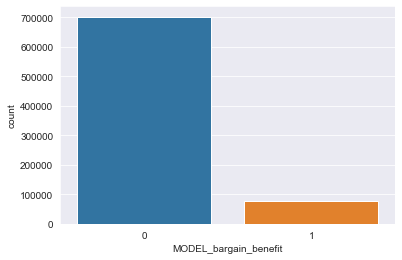

In [8]:
# переведем целевую переменную к бинарному виду для последующей классификации
# примем значения более порога 90 квантиля как успех - 1, остальные как не успех - 0
data = df.copy()
treshold = data.MODEL_bargain_benefit.quantile(0.90)
data.MODEL_bargain_benefit = data.MODEL_bargain_benefit.apply(lambda x: 1 if x > treshold else 0)
# оценим сбалансированность классов
sns.countplot(data=data, x='MODEL_bargain_benefit');

In [10]:
data.MODEL_bargain_benefit.value_counts(normalize=True)

0    0.900057
1    0.099943
Name: MODEL_bargain_benefit, dtype: float64

<AxesSubplot: xlabel='count', ylabel='Month'>

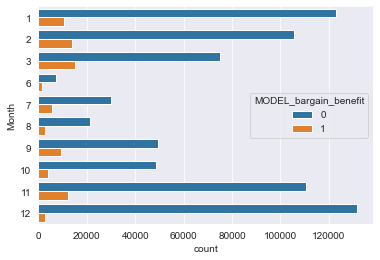

In [11]:
sns.countplot(data=data, y='Month', hue='MODEL_bargain_benefit')

<AxesSubplot: xlabel='count', ylabel='Day_of_week'>

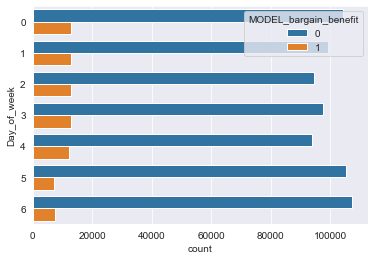

In [12]:
sns.countplot(data=data, y='Day_of_week', hue='MODEL_bargain_benefit')

<AxesSubplot: xlabel='count', ylabel='Quarter'>

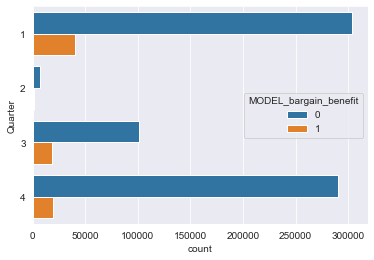

In [13]:
sns.countplot(data=data, y='Quarter', hue='MODEL_bargain_benefit')

<AxesSubplot: xlabel='count', ylabel='is_weekend'>

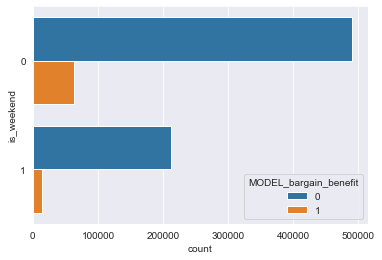

In [14]:
sns.countplot(data=data, y='is_weekend', hue='MODEL_bargain_benefit')

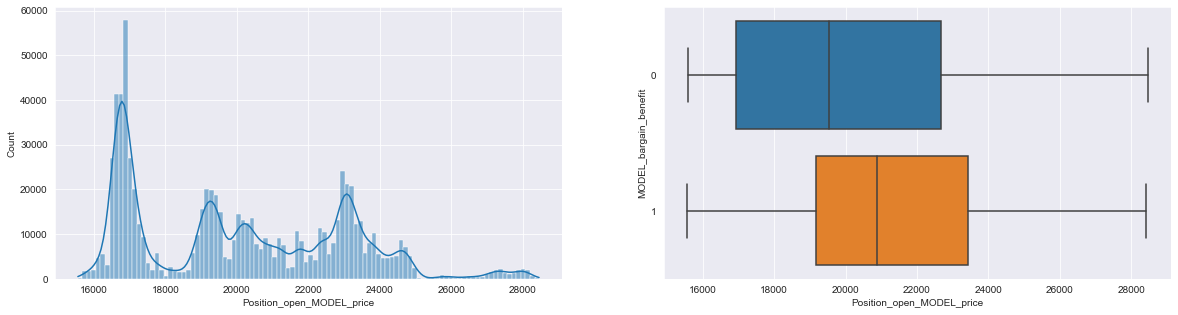

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
#Строим гистограмму Position_open_MODEL_price с таргетом
hist = sns.histplot(data=data, x='Position_open_MODEL_price', kde=True, ax=axes[0])

#Посмотрим распределения в зависимости от целевой переменной
box = sns.boxplot(data=data, x='Position_open_MODEL_price', 
                  y='MODEL_bargain_benefit', orient='h', ax=axes[1])


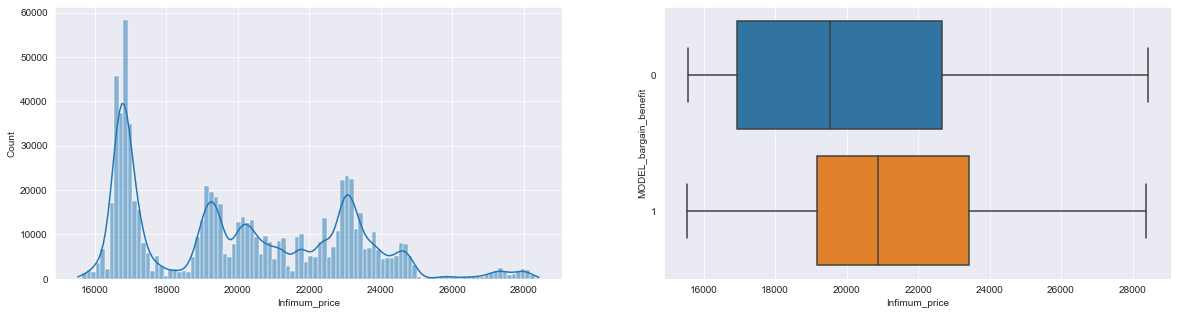

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
#Строим гистограмму Infimum_price с таргетом
hist = sns.histplot(data=data, x='Infimum_price', kde=True, ax=axes[0])

#Посмотрим распределения в зависимости от целевой переменной
box = sns.boxplot(data=data, x='Infimum_price', 
                  y='MODEL_bargain_benefit', orient='h', ax=axes[1])


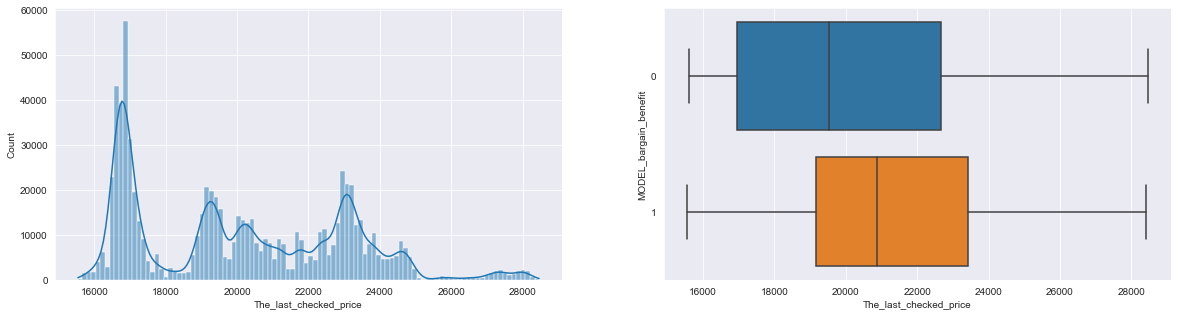

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
#Строим гистограмму The_last_checked_price с таргетом
hist = sns.histplot(data=data, x='The_last_checked_price', kde=True, ax=axes[0])

#Посмотрим распределения в зависимости от целевой переменной
box = sns.boxplot(data=data, x='The_last_checked_price', 
                  y='MODEL_bargain_benefit', orient='h', ax=axes[1])

Пыталась организовать предобработку в цикле, но у меня ноут не тянет и помирает ядро. Так что исследую вручную предоставленные данные, попробую найти взаимосвязи

# Исследование данных признаков на выбросы

##  10. Выбросы по признаку Best_bid_median_after

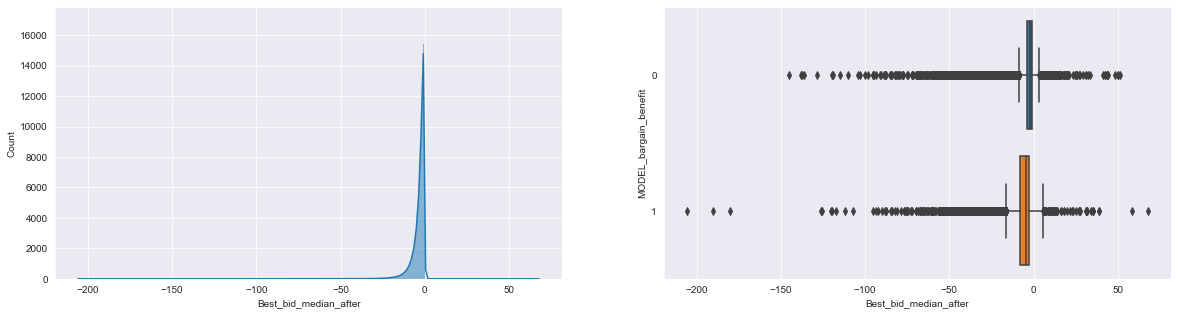

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
#Строим гистограмму Best_bid_median_after с таргетом
hist = sns.histplot(data=data, x='Best_bid_median_after', kde=True, ax=axes[0])

#Посмотрим распределения в зависимости от целевой переменной
box = sns.boxplot(data=data, x='Best_bid_median_after', 
                  y='MODEL_bargain_benefit', orient='h', ax=axes[1])

Довольно много выбросов. Посмотрим сколько этих выбросов по методу Тьюки

In [9]:
def outliers_iqr(data, feature):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned, lower_bound, upper_bound

outliers, cleaned, lower_bound, upper_bound = outliers_iqr(data, 'Best_bid_median_after')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')
print(f'Нижняя граница: {lower_bound}')
print(f'Верхняя граница: {upper_bound}')

Число выбросов по методу Тьюки: 53595
Результирующее число записей: 726348
Нижняя граница: -9.325000000000728
Верхняя граница: 3.835000000002765


In [20]:
cleaned.MODEL_bargain_benefit.value_counts(normalize=True)

0    0.913919
1    0.086081
Name: MODEL_bargain_benefit, dtype: float64

Осталось почти такое же соотношение классов, положительных результатов немного отсеялось, но в принципе можем удалить эти выбросы

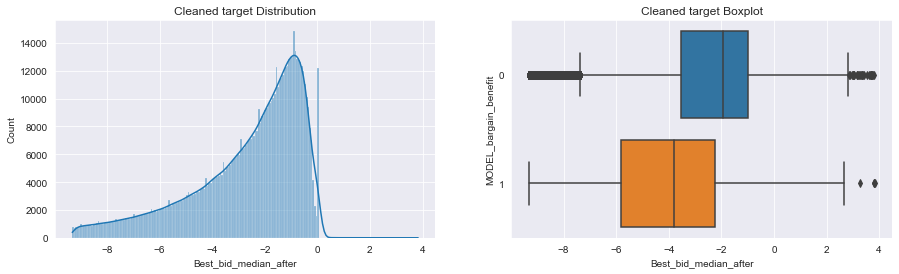

In [21]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=cleaned, x='Best_bid_median_after', kde=True,ax=axes[0]);
histplot.set_title('Cleaned target Distribution');
boxplot = sns.boxplot(data=cleaned, x='Best_bid_median_after', 
                      y='MODEL_bargain_benefit', orient='h', ax=axes[1]);
boxplot.set_title('Cleaned target Boxplot');

Такое распределение гораздо более нормальное

Посмотрю корреляции таргета

# Ранжированный график модульных корреляций признаков с таргетом 

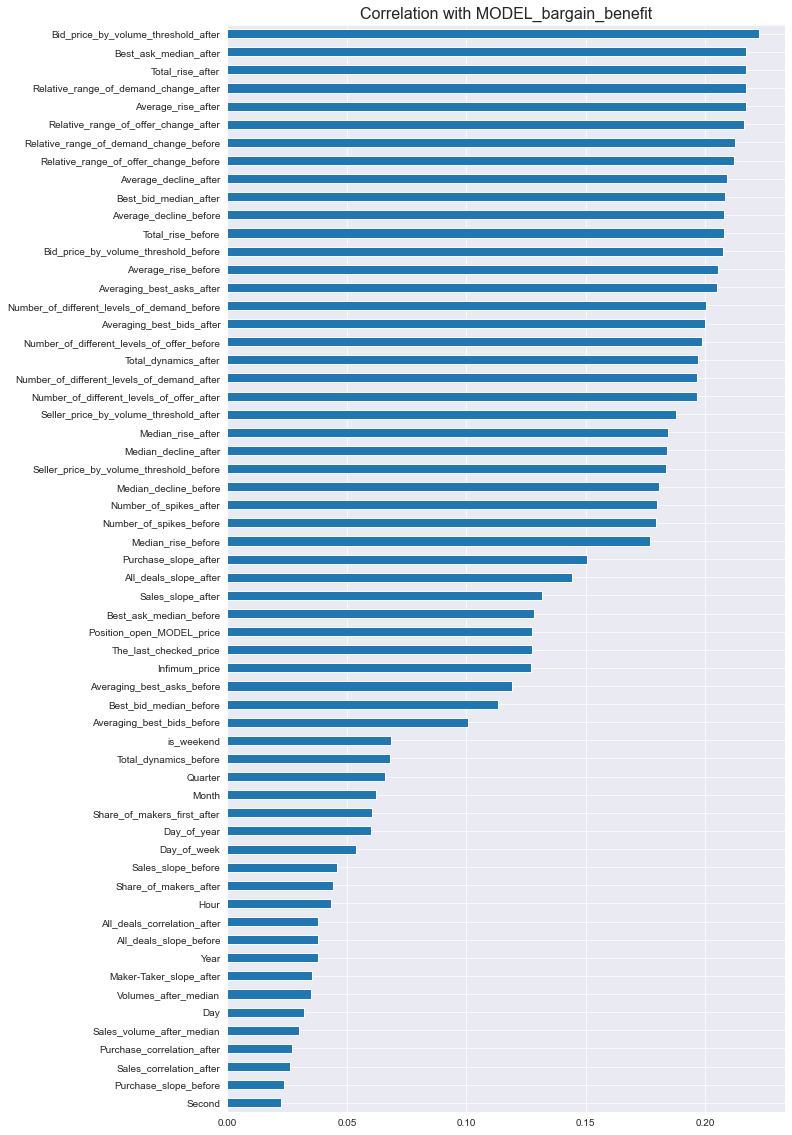

In [22]:
plt.figure(figsize=(10,20))
corr = cleaned.corr()
corr["MODEL_bargain_benefit"].apply(lambda x: abs(x)).sort_values()[-61:-1].plot.barh()
plt.title("Correlation with MODEL_bargain_benefit", fontsize = 16)
plt.show()

In [24]:
corr_rang = corr["MODEL_bargain_benefit"].apply(lambda x: abs(x)).sort_values(ascending=False)
corr_rang.head(11)

MODEL_bargain_benefit                     1.000000
Bid_price_by_volume_threshold_after       0.222400
Best_ask_median_after                     0.217139
Total_rise_after                          0.217124
Relative_range_of_demand_change_after     0.217000
Average_rise_after                        0.216955
Relative_range_of_offer_change_after      0.216053
Relative_range_of_demand_change_before    0.212608
Relative_range_of_offer_change_before     0.212217
Average_decline_after                     0.208920
Best_bid_median_after                     0.208271
Name: MODEL_bargain_benefit, dtype: float64

Как видим, сильных корреляций и очевидной мультиколлинеарности не наблюдается, все признаки скоррелированя слабо или очень слабо. 

Проверю на выбросы первые 10 по значимости признаков

##  1.  Выбросы по признаку Bid_price_by_volume_threshold_after

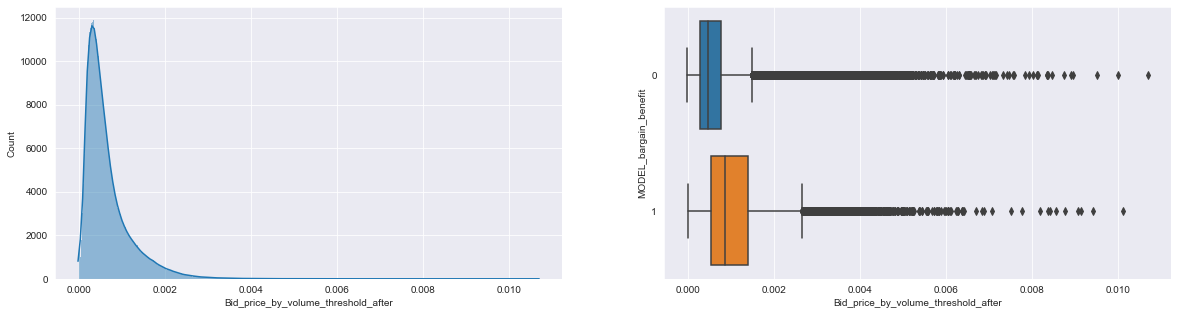

In [25]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
#Строим гистограмму Bid_price_by_volume_threshold_after с таргетом
hist = sns.histplot(data=cleaned, x='Bid_price_by_volume_threshold_after', kde=True, ax=axes[0])

#Посмотрим распределения в зависимости от целевой переменной
box = sns.boxplot(data=cleaned, x='Bid_price_by_volume_threshold_after', 
                  y='MODEL_bargain_benefit', orient='h', ax=axes[1])

In [10]:
outliers_1, cleaned_1, lower_bound_1, upper_bound_1 = outliers_iqr(cleaned, 
                                                                   'Bid_price_by_volume_threshold_after')
print(f'Число выбросов по методу Тьюки: {outliers_1.shape[0]}')
print(f'Результирующее число записей: {cleaned_1.shape[0]}')
print(f'Нижняя граница: {lower_bound_1}')
print(f'Верхняя граница: {upper_bound_1}')

Число выбросов по методу Тьюки: 45701
Результирующее число записей: 680647
Нижняя граница: -0.0004856485267618751
Верхняя граница: 0.0016095363613007252


In [27]:
cleaned_1.MODEL_bargain_benefit.value_counts(normalize=True)

0    0.924672
1    0.075328
Name: MODEL_bargain_benefit, dtype: float64

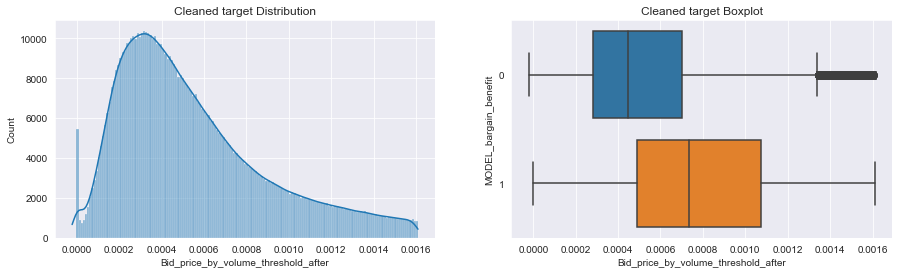

In [28]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=cleaned_1, x='Bid_price_by_volume_threshold_after', kde=True,ax=axes[0]);
histplot.set_title('Cleaned target Distribution');
boxplot = sns.boxplot(data=cleaned_1, x='Bid_price_by_volume_threshold_after', 
                      y='MODEL_bargain_benefit', orient='h', ax=axes[1]);
boxplot.set_title('Cleaned target Boxplot');

##  2. Выбросы по признаку Best_ask_median_after

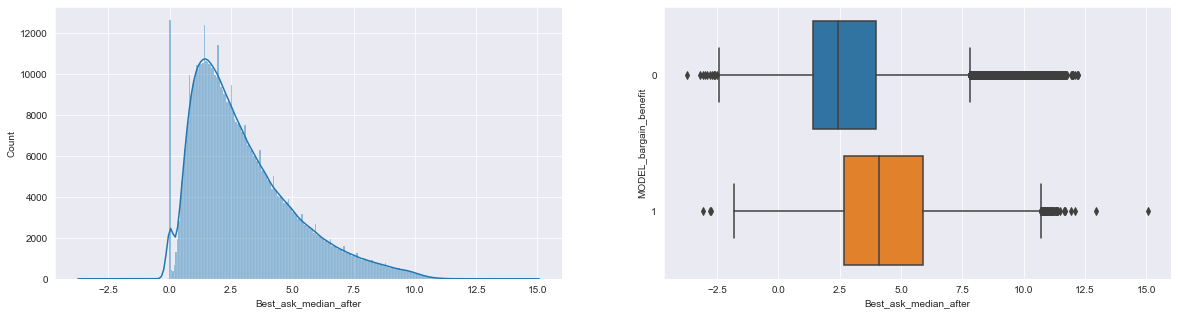

In [29]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
#Строим гистограмму Bid_price_by_volume_threshold_after с таргетом
hist = sns.histplot(data=cleaned_1, x='Best_ask_median_after', kde=True, ax=axes[0])

#Посмотрим распределения в зависимости от целевой переменной
box = sns.boxplot(data=cleaned_1, x='Best_ask_median_after', 
                  y='MODEL_bargain_benefit', orient='h', ax=axes[1])

In [11]:
outliers_2, cleaned_2, lower_bound_2, upper_bound_2 = outliers_iqr(cleaned_1, 
                                                                   'Best_ask_median_after')
print(f'Число выбросов по методу Тьюки: {outliers_2.shape[0]}')
print(f'Результирующее число записей: {cleaned_2.shape[0]}')
print(f'Нижняя граница: {lower_bound_2}')
print(f'Верхняя граница: {upper_bound_2}')

Число выбросов по методу Тьюки: 19049
Результирующее число записей: 661598
Нижняя граница: -2.5749999999952706
Верхняя граница: 8.18499999999949


In [31]:
cleaned_2.MODEL_bargain_benefit.value_counts(normalize=True)

0    0.928136
1    0.071864
Name: MODEL_bargain_benefit, dtype: float64

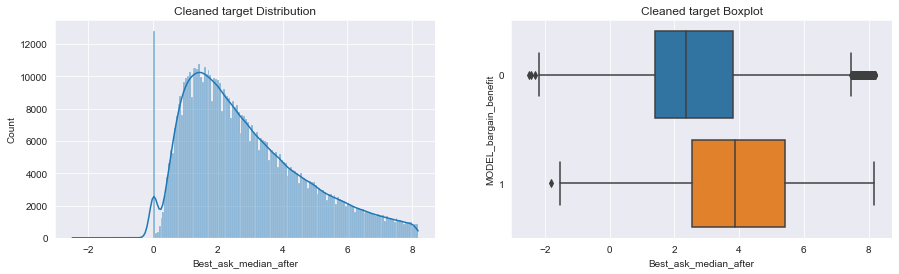

In [32]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=cleaned_2, x='Best_ask_median_after', kde=True,ax=axes[0]);
histplot.set_title('Cleaned target Distribution');
boxplot = sns.boxplot(data=cleaned_2, x='Best_ask_median_after', 
                      y='MODEL_bargain_benefit', orient='h', ax=axes[1]);
boxplot.set_title('Cleaned target Boxplot');

##  3. Выбросы по признаку Total_rise_after

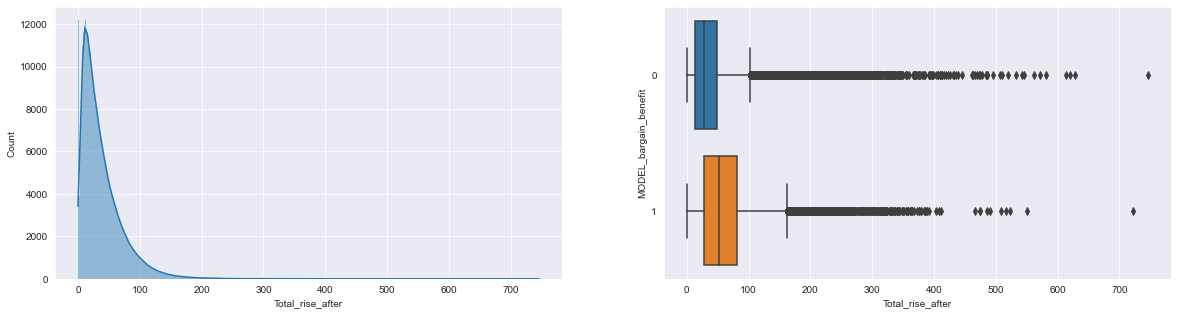

In [33]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
#Строим гистограмму Bid_price_by_volume_threshold_after с таргетом
hist = sns.histplot(data=cleaned_2, x='Total_rise_after', kde=True, ax=axes[0])

#Посмотрим распределения в зависимости от целевой переменной
box = sns.boxplot(data=cleaned_2, x='Total_rise_after', 
                  y='MODEL_bargain_benefit', orient='h', ax=axes[1])

In [12]:
outliers_3, cleaned_3, lower_bound_3, upper_bound_3 = outliers_iqr(cleaned_2, 
                                                                   'Total_rise_after')
print(f'Число выбросов по методу Тьюки: {outliers_3.shape[0]}')
print(f'Результирующее число записей: {cleaned_3.shape[0]}')
print(f'Нижняя граница: {lower_bound_3}')
print(f'Верхняя граница: {upper_bound_3}')

Число выбросов по методу Тьюки: 27829
Результирующее число записей: 633769
Нижняя граница: -41.17499999992242
Верхняя граница: 107.50499999993599


In [35]:
cleaned_3.MODEL_bargain_benefit.value_counts(normalize=True)

0    0.934344
1    0.065656
Name: MODEL_bargain_benefit, dtype: float64

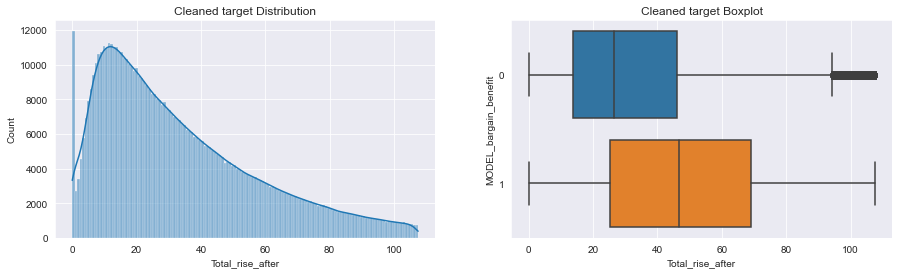

In [36]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=cleaned_3, x='Total_rise_after', kde=True,ax=axes[0]);
histplot.set_title('Cleaned target Distribution');
boxplot = sns.boxplot(data=cleaned_3, x='Total_rise_after', 
                      y='MODEL_bargain_benefit', orient='h', ax=axes[1]);
boxplot.set_title('Cleaned target Boxplot');

##  4. Выбросы по признаку Relative_range_of_demand_change_after

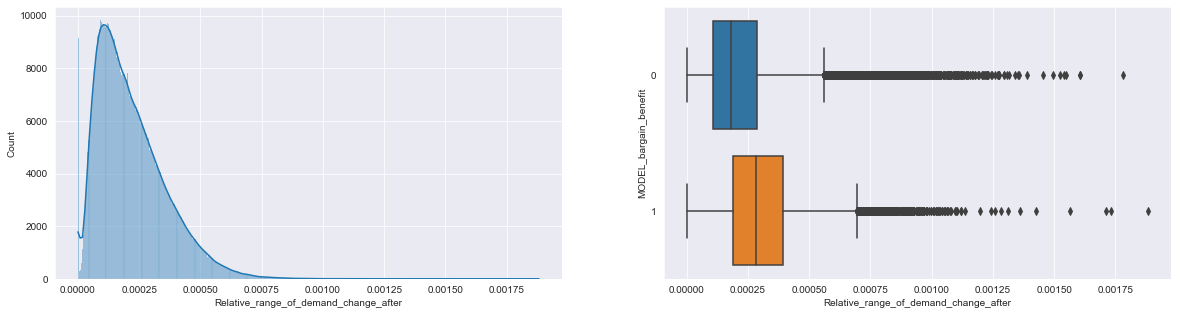

In [37]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
#Строим гистограмму Bid_price_by_volume_threshold_after с таргетом
hist = sns.histplot(data=cleaned_3, x='Relative_range_of_demand_change_after', kde=True, ax=axes[0])

#Посмотрим распределения в зависимости от целевой переменной
box = sns.boxplot(data=cleaned_3, x='Relative_range_of_demand_change_after', 
                  y='MODEL_bargain_benefit', orient='h', ax=axes[1])

In [13]:
outliers_4, cleaned_4, lower_bound_4, upper_bound_4 = outliers_iqr(cleaned_3, 
                                                                   'Relative_range_of_demand_change_after')
print(f'Число выбросов по методу Тьюки: {outliers_4.shape[0]}')
print(f'Результирующее число записей: {cleaned_4.shape[0]}')
print(f'Нижняя граница: {lower_bound_4}')
print(f'Верхняя граница: {upper_bound_4}')

Число выбросов по методу Тьюки: 11940
Результирующее число записей: 621829
Нижняя граница: -0.00016804594025455005
Верхняя граница: 0.0005766227162922501


In [39]:
cleaned_4.MODEL_bargain_benefit.value_counts(normalize=True)

0    0.936425
1    0.063575
Name: MODEL_bargain_benefit, dtype: float64

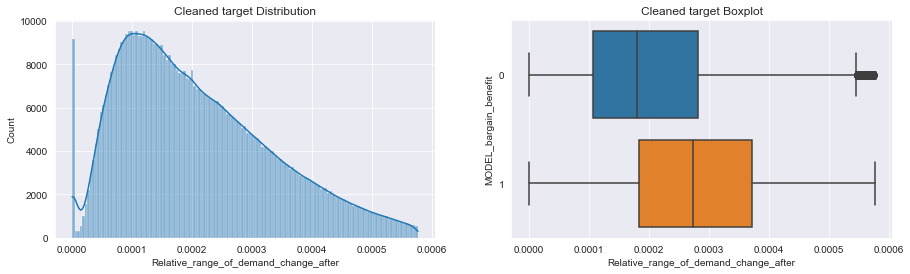

In [40]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=cleaned_4, x='Relative_range_of_demand_change_after', kde=True,ax=axes[0]);
histplot.set_title('Cleaned target Distribution');
boxplot = sns.boxplot(data=cleaned_4, x='Relative_range_of_demand_change_after', 
                      y='MODEL_bargain_benefit', orient='h', ax=axes[1]);
boxplot.set_title('Cleaned target Boxplot');

##  5. Выбросы по признаку Average_rise_after

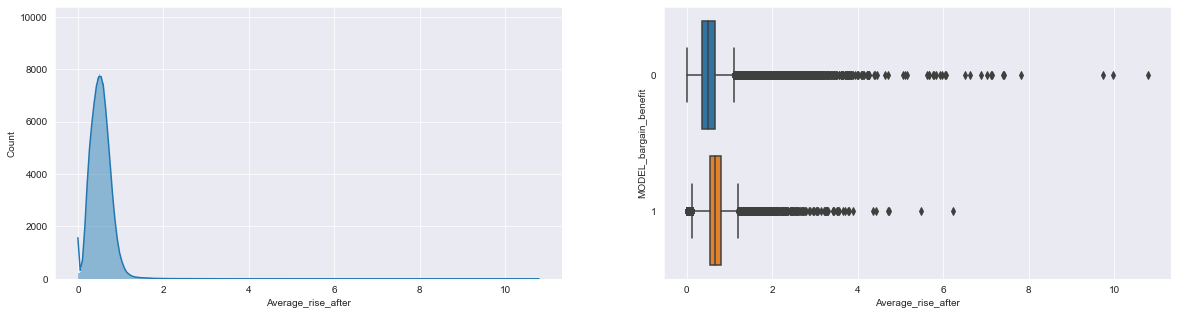

In [41]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
#Строим гистограмму Bid_price_by_volume_threshold_after с таргетом
hist = sns.histplot(data=cleaned_4, x='Average_rise_after', kde=True, ax=axes[0])

#Посмотрим распределения в зависимости от целевой переменной
box = sns.boxplot(data=cleaned_4, x='Average_rise_after', 
                  y='MODEL_bargain_benefit', orient='h', ax=axes[1])

In [14]:
outliers_5, cleaned_5, lower_bound_5, upper_bound_5 = outliers_iqr(cleaned_4, 
                                                                   'Average_rise_after')
print(f'Число выбросов по методу Тьюки: {outliers_5.shape[0]}')
print(f'Результирующее число записей: {cleaned_5.shape[0]}')
print(f'Нижняя граница: {lower_bound_5}')
print(f'Верхняя граница: {upper_bound_5}')

Число выбросов по методу Тьюки: 7579
Результирующее число записей: 614250
Нижняя граница: -0.09253289473665938
Верхняя граница: 1.1308881578946641


In [43]:
cleaned_5.MODEL_bargain_benefit.value_counts(normalize=True)

0    0.937928
1    0.062072
Name: MODEL_bargain_benefit, dtype: float64

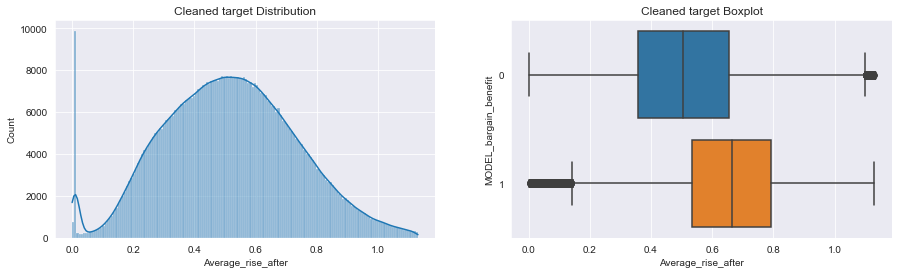

In [44]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=cleaned_5, x='Average_rise_after', kde=True,ax=axes[0]);
histplot.set_title('Cleaned target Distribution');
boxplot = sns.boxplot(data=cleaned_5, x='Average_rise_after', 
                      y='MODEL_bargain_benefit', orient='h', ax=axes[1]);
boxplot.set_title('Cleaned target Boxplot');

##  6. Выбросы по признаку Relative_range_of_offer_change_after

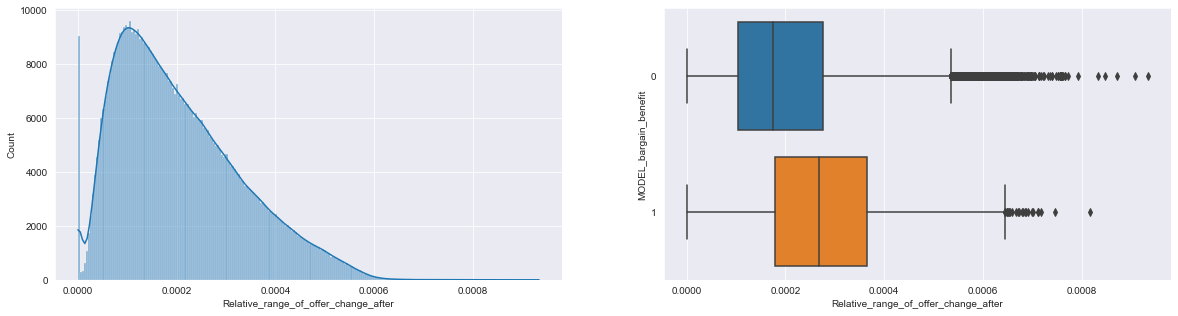

In [45]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
#Строим гистограмму Bid_price_by_volume_threshold_after с таргетом
hist = sns.histplot(data=cleaned_5, x='Relative_range_of_offer_change_after', kde=True, ax=axes[0])

#Посмотрим распределения в зависимости от целевой переменной
box = sns.boxplot(data=cleaned_5, x='Relative_range_of_offer_change_after', 
                  y='MODEL_bargain_benefit', orient='h', ax=axes[1])

In [15]:
outliers_6, cleaned_6, lower_bound_6, upper_bound_6 = outliers_iqr(cleaned_5, 
                                                                   'Relative_range_of_offer_change_after')
print(f'Число выбросов по методу Тьюки: {outliers_6.shape[0]}')
print(f'Результирующее число записей: {cleaned_6.shape[0]}')
print(f'Нижняя граница: {lower_bound_6}')
print(f'Верхняя граница: {upper_bound_6}')

Число выбросов по методу Тьюки: 4333
Результирующее число записей: 609917
Нижняя граница: -0.00015883133357470005
Верхняя граница: 0.0005491738952003


In [47]:
cleaned_6.MODEL_bargain_benefit.value_counts(normalize=True)

0    0.938506
1    0.061494
Name: MODEL_bargain_benefit, dtype: float64

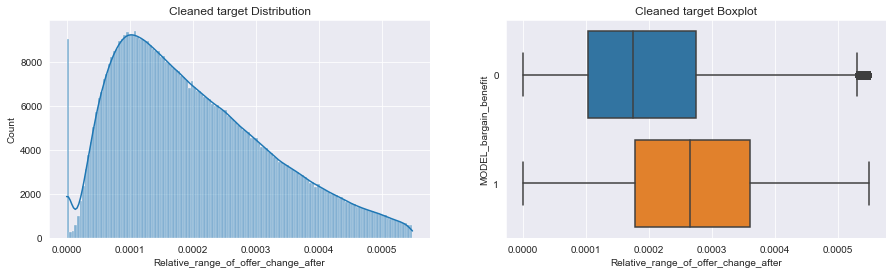

In [48]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=cleaned_6, x='Relative_range_of_offer_change_after', kde=True,ax=axes[0]);
histplot.set_title('Cleaned target Distribution');
boxplot = sns.boxplot(data=cleaned_6, x='Relative_range_of_offer_change_after', 
                      y='MODEL_bargain_benefit', orient='h', ax=axes[1]);
boxplot.set_title('Cleaned target Boxplot');

##  7. Выбросы по признаку Relative_range_of_demand_change_before

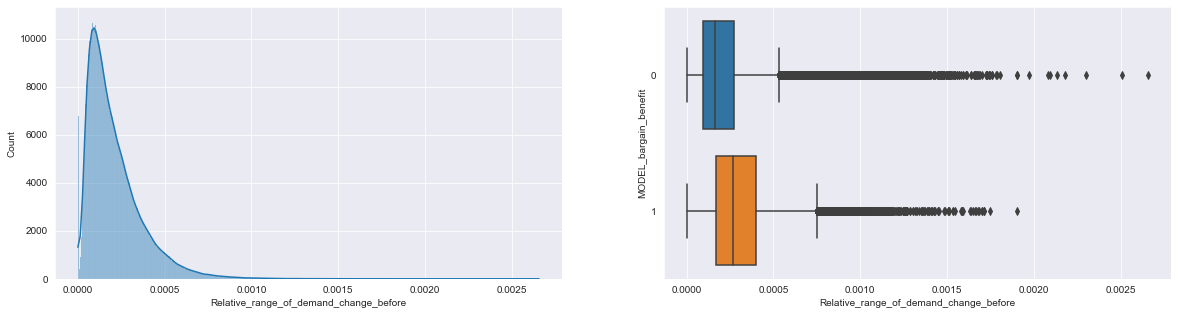

In [49]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
#Строим гистограмму Relative_range_of_demand_change_before с таргетом
hist = sns.histplot(data=cleaned_6, x='Relative_range_of_demand_change_before', kde=True, ax=axes[0])

#Посмотрим распределения в зависимости от целевой переменной
box = sns.boxplot(data=cleaned_6, x='Relative_range_of_demand_change_before', 
                  y='MODEL_bargain_benefit', orient='h', ax=axes[1])

In [16]:
outliers_7, cleaned_7, lower_bound_7, upper_bound_7 = outliers_iqr(cleaned_6, 
                                                                   'Relative_range_of_demand_change_before')
print(f'Число выбросов по методу Тьюки: {outliers_7.shape[0]}')
print(f'Результирующее число записей: {cleaned_7.shape[0]}')
print(f'Нижняя граница: {lower_bound_7}')
print(f'Верхняя граница: {upper_bound_7}')

Число выбросов по методу Тьюки: 23590
Результирующее число записей: 586327
Нижняя граница: -0.00017714793814593187
Верхняя граница: 0.000553451594298919


In [51]:
cleaned_7.MODEL_bargain_benefit.value_counts(normalize=True)

0    0.942319
1    0.057681
Name: MODEL_bargain_benefit, dtype: float64

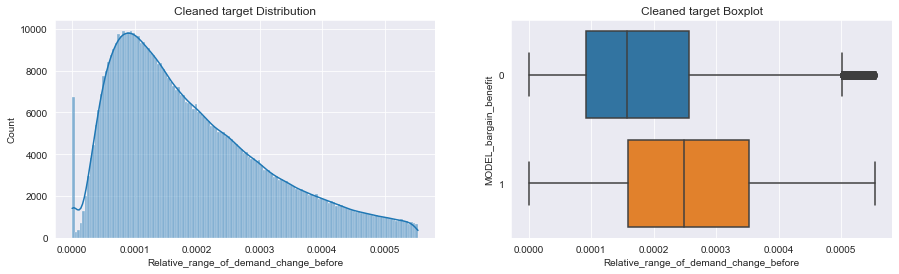

In [52]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=cleaned_7, x='Relative_range_of_demand_change_before', kde=True,ax=axes[0]);
histplot.set_title('Cleaned target Distribution');
boxplot = sns.boxplot(data=cleaned_7, x='Relative_range_of_demand_change_before', 
                      y='MODEL_bargain_benefit', orient='h', ax=axes[1]);
boxplot.set_title('Cleaned target Boxplot');

##  8. Выбросы по признаку Relative_range_of_offer_change_before

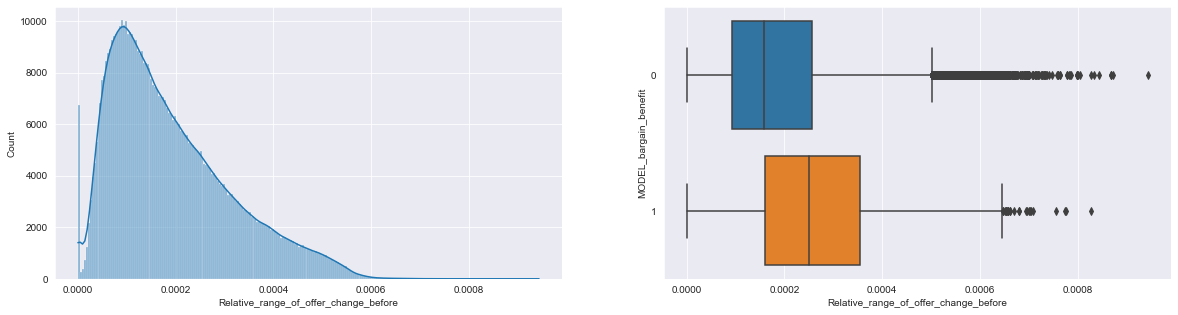

In [53]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
#Строим гистограмму Relative_range_of_offer_change_before с таргетом
hist = sns.histplot(data=cleaned_7, x='Relative_range_of_offer_change_before', kde=True, ax=axes[0])

#Посмотрим распределения в зависимости от целевой переменной
box = sns.boxplot(data=cleaned_7, x='Relative_range_of_offer_change_before', 
                  y='MODEL_bargain_benefit', orient='h', ax=axes[1])

In [17]:
outliers_8, cleaned_8, lower_bound_8, upper_bound_8 = outliers_iqr(cleaned_7, 
                                                                   'Relative_range_of_offer_change_before')
print(f'Число выбросов по методу Тьюки: {outliers_8.shape[0]}')
print(f'Результирующее число записей: {cleaned_8.shape[0]}')
print(f'Нижняя граница: {lower_bound_8}')
print(f'Верхняя граница: {upper_bound_8}')

Число выбросов по методу Тьюки: 7933
Результирующее число записей: 578394
Нижняя граница: -0.0001583427103322735
Верхняя граница: 0.0005165871759684841


In [55]:
cleaned_8.MODEL_bargain_benefit.value_counts(normalize=True)

0    0.943338
1    0.056662
Name: MODEL_bargain_benefit, dtype: float64

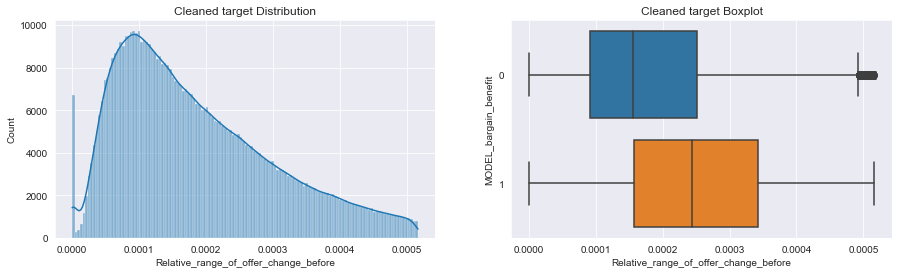

In [56]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=cleaned_8, x='Relative_range_of_offer_change_before', kde=True,ax=axes[0]);
histplot.set_title('Cleaned target Distribution');
boxplot = sns.boxplot(data=cleaned_8, x='Relative_range_of_offer_change_before', 
                      y='MODEL_bargain_benefit', orient='h', ax=axes[1]);
boxplot.set_title('Cleaned target Boxplot');

##  9. Выбросы по признаку Average_decline_after

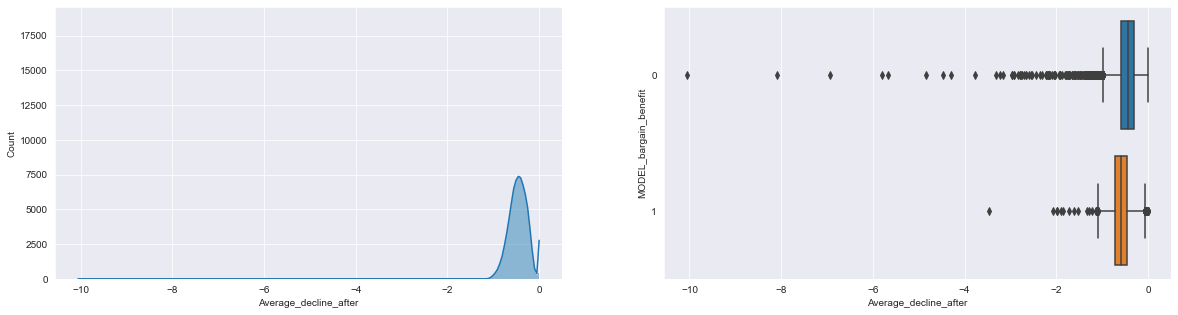

In [57]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
#Строим гистограмму Average_decline_after с таргетом
hist = sns.histplot(data=cleaned_8, x='Average_decline_after', kde=True, ax=axes[0])

#Посмотрим распределения в зависимости от целевой переменной
box = sns.boxplot(data=cleaned_8, x='Average_decline_after', 
                  y='MODEL_bargain_benefit', orient='h', ax=axes[1])

In [18]:
outliers_9, cleaned_9, lower_bound_9, upper_bound_9 = outliers_iqr(cleaned_8, 
                                                                   'Average_decline_after')
print(f'Число выбросов по методу Тьюки: {outliers_9.shape[0]}')
print(f'Результирующее число записей: {cleaned_9.shape[0]}')
print(f'Нижняя граница: {lower_bound_9}')
print(f'Верхняя граница: {upper_bound_9}')

Число выбросов по методу Тьюки: 2166
Результирующее число записей: 576228
Нижняя граница: -0.999227331556945
Верхняя граница: 0.09623662776708936


In [59]:
cleaned_9.MODEL_bargain_benefit.value_counts(normalize=True)

0    0.943685
1    0.056315
Name: MODEL_bargain_benefit, dtype: float64

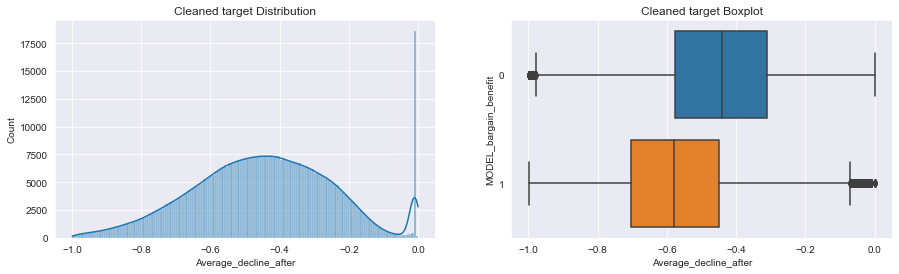

In [60]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=cleaned_9, x='Average_decline_after', kde=True,ax=axes[0]);
histplot.set_title('Cleaned target Distribution');
boxplot = sns.boxplot(data=cleaned_9, x='Average_decline_after', 
                      y='MODEL_bargain_benefit', orient='h', ax=axes[1]);
boxplot.set_title('Cleaned target Boxplot');

Пока мы провели довольно "грубую" очистку от выбросов - просто удалив строки с выбросами, осталось в результате 576228 строк из исходного  779943 строки датасета. Всего удалено 203715 строки, что составляет 26% от изначального датасета, это довольно много. Пока для baseline построю базовые модели на основе таких данных

# Кодирование и стандартизация переменных

In [9]:
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn.preprocessing  import MinMaxScaler
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import cross_validate 
from sklearn.model_selection import train_test_split 

In [20]:
cleaned_9.describe()

,Infimum_price,The_last_checked_price,Best_bid_median_after,Best_bid_slope_after,Best_ask_median_after,Best_ask_slope_after,Number_of_different_levels_of_demand_after,Relative_range_of_demand_change_after,Number_of_different_levels_of_offer_after,Relative_range_of_offer_change_after,Maker-Taker_slope_after,Maker-Taker_correlation_after,Share_of_makers_after,Share_of_makers_first_after,All_deals_slope_after,All_deals_correlation_after,All_volumes_slope_after,All_volumes_correlation_after,Sales_slope_after,Sales_correlation_after,Purchase_slope_after,Purchase_correlation_after,Sales_volume_slope_after,Sales_volume_correlation_after,Purchase_volume_slope_after,Purchase_volume_correlation_after,Number_of_spikes_after,Total_rise_after,Median_rise_after,Average_rise_after,Total_dynamics_after,Median_decline_after,Average_decline_after,Volumes_after_median,Sales_volume_after_median,Purchase_volume_after_median,Bid_price_by_volume_threshold_after,Seller_price_by_volume_threshold_after,Averaging_best_bids_before,Averaging_best_asks_before,Averaging_best_bids_after,Averaging_best_asks_after,Best_bid_median_before,Best_bid_slope_before,Best_ask_median_before,Best_ask_slope_before,Number_of_different_levels_of_demand_before,Relative_range_of_demand_change_before,Number_of_different_levels_of_offer_before,Relative_range_of_offer_change_before,Maker-Taker_slope_before,Maker-Taker_correlation_before,Share_of_makers_before,Share_of_makers_first_before,All_deals_slope_before,All_deals_correlation_before,All_volumes_slope_before,All_volumes_correlation_before,Sales_slope_before,Sales_correlation_before,Purchase_slope_before,Purchase_correlation_before,Sales_volume_slope_before,Sales_volume_correlation_before,Purchase_volume_slope_before,Purchase_volume_correlation_before,Number_of_spikes_before,Total_rise_before,Median_rise_before,Average_rise_before,Total_dynamics_before,Median_decline_before,Average_decline_before,Volumes_before_median,Sales_volume_before_median,Purchase_volume_before_median,Bid_price_by_volume_threshold_before,Seller_price_by_volume_threshold_before,Position_open_MODEL_price,MODEL_bargain_benefit,Second,Minute,Hour,Day,Month,Day_of_week,is_weekend,Day_of_year,Year,Quarter
count,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,5.762280e+05,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,5.762280e+05,5.762280e+05,5.762280e+05,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000
mean,19708.383977,19711.425395,-1.978358,-0.157285,2.535286,0.173335,140.275514,0.000197,133.389957,0.000195,-6.156709,-0.472095,0.406600,0.171282,0.194049,0.438921,-0.000699,-0.020089,0.176362,0.420822,0.223062,0.521949,0.000127,0.013143,-0.001230,-0.032883,112.696686,30.988099,0.438276,0.504385,3.025989,-0.402923,-0.451806,0.008017,0.007798,0.008657,0.000464,-0.000235,0.000078,0.000113,0.000092,0.000130,-1.674199,-0.006919,2.228959,-0.012171,131.823669,0.000185,134.217702,0.000185,1.908757,0.137923,0.536647,0.236893,-

In [21]:
len(num_features)

79

In [22]:
cat_features = ['Second', 'Minute', 'Hour', 'Day', 'Month', 'Day_of_week', 'is_weekend',
                'Day_of_year', 'Year', 'Quarter']

In [23]:
data_scaled = cleaned_9.copy()

# функция для кодирования,
def LabelEncoder_column(d_col):
    le = LabelEncoder()
    le.fit(data_scaled[[d_col]])
    return le.transform(data_scaled[[d_col]])

for i  in list(data_scaled.columns):
    if i in cat_features:
        data_scaled[i] = LabelEncoder_column(i)



# функция для стандартизации,
def MinMaxScaler_column(d_col):
    mscaler = MinMaxScaler()
    mscaler.fit(data_scaled[[d_col]])
    return mscaler.transform(data_scaled[[d_col]])

for i in list(data_scaled.columns):
    data_scaled[i] = MinMaxScaler_column(i)

data_scaled


,Infimum_price,The_last_checked_price,Best_bid_median_after,Best_bid_slope_after,Best_ask_median_after,Best_ask_slope_after,Number_of_different_levels_of_demand_after,Relative_range_of_demand_change_after,Number_of_different_levels_of_offer_after,Relative_range_of_offer_change_after,Maker-Taker_slope_after,Maker-Taker_correlation_after,Share_of_makers_after,Share_of_makers_first_after,All_deals_slope_after,All_deals_correlation_after,All_volumes_slope_after,All_volumes_correlation_after,Sales_slope_after,Sales_correlation_after,Purchase_slope_after,Purchase_correlation_after,Sales_volume_slope_after,Sales_volume_correlation_after,Purchase_volume_slope_after,Purchase_volume_correlation_after,Number_of_spikes_after,Total_rise_after,Median_rise_after,Average_rise_after,Total_dynamics_after,Median_decline_after,Average_decline_after,Volumes_after_median,Sales_volume_after_median,Purchase_volume_after_median,Bid_price_by_volume_threshold_after,Seller_price_by_volume_threshold_after,Averaging_best_bids_before,Averaging_best_asks_before,Averaging_best_bids_after,Averaging_best_asks_after,Best_bid_median_before,Best_bid_slope_before,Best_ask_median_before,Best_ask_slope_before,Number_of_different_levels_of_demand_before,Relative_range_of_demand_change_before,Number_of_different_levels_of_offer_before,Relative_range_of_offer_change_before,Maker-Taker_slope_before,Maker-Taker_correlation_before,Share_of_makers_before,Share_of_makers_first_before,All_deals_slope_before,All_deals_correlation_before,All_volumes_slope_before,All_volumes_correlation_before,Sales_slope_before,Sales_correlation_before,Purchase_slope_before,Purchase_correlation_before,Sales_volume_slope_before,Sales_volume_correlation_before,Purchase_volume_slope_before,Purchase_volume_correlation_before,Number_of_spikes_before,Total_rise_before,Median_rise_before,Average_rise_before,Total_dynamics_before,Median_decline_before,Average_decline_before,Volumes_before_median,Sales_volume_before_median,Purchase_volume_before_median,Bid_price_by_volume_threshold_before,Seller_price_by_volume_threshold_before,Position_open_MODEL_price,MODEL_bargain_benefit,Second,Minute,Hour,Day,Month,Day_of_week,is_weekend,Day_of_year,Year,Quarter
0,0.366937,0.366972,0.570313,0.164582,0.420880,0.799323,0.022222,0.500413,0.016692,0.525375,0.582903,0.077524,0.180385,0.250000,0.501301,0.889974,0.440289,0.512693,0.288406,0.915205,0.146117,0.871889,0.965486,0.462628,0.837222,0.492907,0.048387,0.055442,0.005952,0.439299,0.458960,0.992593,0.989991,0.027627,0.002500,0.011717,0.134808,0.875703,0.612206,0.637717,0.506095,0.242275,0.394353,0.707500,0.596407,0.254762,0.040214,0.409922,0.041026,0.439166,0.615624,0.859304,0.609756,0.536585,0.310373,0.176698,0.592799,0.560391,0.824114,0.095898,0.589161,0.316457,0.000003,0.535984,0.527837,0.454313,0.044313,0.029209,0.000909,0.053515,0.577948,0.998795,0.976867,0.017943,0.002557,0.008676,0.127073,0.899519,0.366862,0.0,0.254237,0.000000,0.173913,0.933333,0.333333,0.333333,0.0,0.437158,0.0,0.333333
1,0.367401,0.367050,0.709201,0.164609,0.234551,0.799300,0.004167,0.083806,0.001517,0.087986,0.595321,0.025593,0.198225,0.153846,0.318433,0.850692,0.447078,0.526782,0.219108,0.935763,0.079125,0.821750,0.965393,0.324204,0.839031,0.542023,0.026210,0.009674,0.005952,0.153313,0.292408,0.992593,0.989991,0.055820,0.002500,0.025366,0.148564,0.763465,0.334196,0.309243,0.257589,0.174407,0.655434,0.707432,0.335629,0.254842,0.020107,0.521164,0.012821,0.558343,0.573439,0.064777,0.111111,0.111111,0.489527,0.890330,0.568699,0.470830,0.858320,0.953746,0.613487,0.874984,0.000003,0.414082,0.527836,0.463400,0.025111,0.000298,0.000909,0.000909,0.243764,0.998795,0.910693,0.023651,0.002556,0.017671,0.039098,0.844878,0.366862,0.0,0.457627,0.000000,0.173913,0.933333,0.333333,0.333333,0.0,0.437158,0.0,0.333333
2,0.367137,0.366708,0.709201,0.164628,0.234551,0.799283,0.005556,0.281393,0.012140,0.295430,0.602904,0.083334,0.402000,0.380000,0.291044,0.409354,0.439889,0.503087,0.199123,0.498372,0.071302,0.

In [24]:
data_scaled.describe()

,Infimum_price,The_last_checked_price,Best_bid_median_after,Best_bid_slope_after,Best_ask_median_after,Best_ask_slope_after,Number_of_different_levels_of_demand_after,Relative_range_of_demand_change_after,Number_of_different_levels_of_offer_after,Relative_range_of_offer_change_after,Maker-Taker_slope_after,Maker-Taker_correlation_after,Share_of_makers_after,Share_of_makers_first_after,All_deals_slope_after,All_deals_correlation_after,All_volumes_slope_after,All_volumes_correlation_after,Sales_slope_after,Sales_correlation_after,Purchase_slope_after,Purchase_correlation_after,Sales_volume_slope_after,Sales_volume_correlation_after,Purchase_volume_slope_after,Purchase_volume_correlation_after,Number_of_spikes_after,Total_rise_after,Median_rise_after,Average_rise_after,Total_dynamics_after,Median_decline_after,Average_decline_after,Volumes_after_median,Sales_volume_after_median,Purchase_volume_after_median,Bid_price_by_volume_threshold_after,Seller_price_by_volume_threshold_after,Averaging_best_bids_before,Averaging_best_asks_before,Averaging_best_bids_after,Averaging_best_asks_after,Best_bid_median_before,Best_bid_slope_before,Best_ask_median_before,Best_ask_slope_before,Number_of_different_levels_of_demand_before,Relative_range_of_demand_change_before,Number_of_different_levels_of_offer_before,Relative_range_of_offer_change_before,Maker-Taker_slope_before,Maker-Taker_correlation_before,Share_of_makers_before,Share_of_makers_first_before,All_deals_slope_before,All_deals_correlation_before,All_volumes_slope_before,All_volumes_correlation_before,Sales_slope_before,Sales_correlation_before,Purchase_slope_before,Purchase_correlation_before,Sales_volume_slope_before,Sales_volume_correlation_before,Purchase_volume_slope_before,Purchase_volume_correlation_before,Number_of_spikes_before,Total_rise_before,Median_rise_before,Average_rise_before,Total_dynamics_before,Median_decline_before,Average_decline_before,Volumes_before_median,Sales_volume_before_median,Purchase_volume_before_median,Bid_price_by_volume_threshold_before,Seller_price_by_volume_threshold_before,Position_open_MODEL_price,MODEL_bargain_benefit,Second,Minute,Hour,Day,Month,Day_of_week,is_weekend,Day_of_year,Year,Quarter
count,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000,576228.000000
mean,0.321852,0.321656,0.537469,0.164607,0.471001,0.799302,0.193438,0.342480,0.200895,0.355136,0.580965,0.264065,0.419111,0.342565,0.346987,0.721991,0.439094,0.487860,0.222004,0.709468,0.092633,0.758245,0.965489,0.506571,0.837097,0.483558,0.227211,0.288261,0.260878,0.446127,0.362722,0.701539,0.547806,0.019777,0.001950,0.008446,0.297821,0.780769,0.449276,0.502115,0.386106,0.331178,0.542678,0.707491,0.463142,0.254772,0.175367,0.334509,0.170792,0.358970,0.612980,0.569309,0.536647,0.473785,0.344840,0.384203,0.572641,0.5

## Стратифицированное разбиение выборки на тренировочную и тестовую часть

In [25]:
X = data_scaled.drop(['MODEL_bargain_benefit'], axis=1)
y = data_scaled['MODEL_bargain_benefit']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.25)

In [26]:
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))
print(y_train.mean().round(2))
print(y_test.mean().round(2))

Train shape: (432171, 89)
Test shape: (144057, 89)
0.06
0.06


# Базовые модели классификации

## Модель логистической регрессии

In [10]:
# зафиксируем random_state
random_state=42

In [29]:
%%time

#Создаем объект класса логистическая регрессия
lr = linear_model.LogisticRegression(max_iter = 1000, random_state=random_state,
                                    class_weight='balanced')
#Обучаем модель, минимизируя logloss
lr.fit(X_train, y_train)

y_train_pred = lr.predict(X_train)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_train, y_train_pred))

y_test_pred = lr.predict(X_test)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

         0.0       0.97      0.68      0.80    407833
         1.0       0.12      0.71      0.20     24338

    accuracy                           0.68    432171
   macro avg       0.55      0.69      0.50    432171
weighted avg       0.93      0.68      0.77    432171

              precision    recall  f1-score   support

         0.0       0.97      0.68      0.80    135945
         1.0       0.12      0.70      0.20      8112

    accuracy                           0.68    144057
   macro avg       0.54      0.69      0.50    144057
weighted avg       0.93      0.68      0.77    144057

CPU times: user 8min 48s, sys: 2min 33s, total: 11min 21s
Wall time: 1min 34s


     ◦ Precision для класса 1 составляет  0.12, то есть из всех примеров, причисленных моделью к классу успешных, 12 % действительно являются таковыми. 
     ◦ Recall для класса 1 составляет 0.70, то есть из всех примеров в действительности успешных модель посчитала успешными 70%, а остальные 30 % посчитала неуспешными. 

## Модель дерева решений

In [31]:
%%time

#Создаём модель
te = tree.DecisionTreeClassifier(
    random_state=random_state, #генератор случайных чисел
    class_weight='balanced' #веса классов
)
#Обучаем модель на тренировочной выборке
te.fit(X_train, y_train)

y_train_pred = te.predict(X_train)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_train, y_train_pred))

y_test_pred = te.predict(X_test)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    407833
         1.0       1.00      1.00      1.00     24338

    accuracy                           1.00    432171
   macro avg       1.00      1.00      1.00    432171
weighted avg       1.00      1.00      1.00    432171

              precision    recall  f1-score   support

         0.0       0.95      0.94      0.95    135945
         1.0       0.11      0.11      0.11      8112

    accuracy                           0.90    144057
   macro avg       0.53      0.53      0.53    144057
weighted avg       0.90      0.90      0.90    144057

CPU times: user 1min 27s, sys: 192 ms, total: 1min 27s
Wall time: 1min 28s


     ◦ Precision для класса 1 составляет  0.11, то есть из всех примеров, причисленных моделью к классу успешных, 11 % действительно являются таковыми. 
     ◦ Recall для класса 1 составляет 0.11, то есть из всех примеров в действительности успешных модель посчитала успешными лишь 11 %, а остальные 89 % посчитала неуспешными. 

Итак, базовые модели без настроек находят лишь 11% успешных исходов среди действительно успешных исходов. Это очень плохой результат, настройкой гиперпараметров и ансамблей моделей можно попробовать поискать более хорошие результаты, но из настолько плохого начального результата это вряд ли даст прорыв. Необходимо лучше изучить и подобрать данные для обучения

Гипотеза.
Возможно, более эффективно будет провести обучение в несколько этапов - сначала выделить в класс успешных значения таргета более или равно нулю (раз уж у нас есть условие торгов без комиссии, логично, что даже нулевая сделка уже как минимум не потеря денег). А следующим этапом, если на этом получатся хорошие метрики, построить модель, которая их хороших результатов будет искать наилучшие

# Проверка моделей без обработки выбросов и с классификацией успешности результата при нулевом или положительном значении таргета 

In [4]:
df = pd.read_csv('data/trading_estimations_2023_03-21_fix.csv')
df.columns = [column.replace(' ','_') for column in df.columns]
df.columns = [column.replace(':','_') for column in df.columns]
df.columns = [column.replace('.','_') for column in df.columns]
df['Date'] = pd.to_datetime(df['Unnamed__0'])
df.drop(['Unnamed__0_1', 'Unnamed__0'], axis=1, inplace=True)
# создам признаки на основе даты
df['Second'] = df.Date.dt.second
df['Minute'] = df.Date.dt.minute
df['Hour'] = df.Date.dt.hour
df['Day'] = df.Date.dt.day
df['Month'] = df.Date.dt.month
df['Day_of_week'] = df.Date.dt.weekday
df['is_weekend'] = df.Date.dt.weekday.apply(lambda x: 1 if x > 4 else 0)
df['Day_of_year'] = df.Date.dt.dayofyear
df['Year'] = df.Date.dt.year
df['Quarter'] = df.Date.dt.quarter
# удалим более не нужную дату
df.drop('Date', axis=1, inplace=True)

df['Class_positive'] = df.MODEL_bargain_benefit.apply(lambda x: 1 if x >=0 else 0)


df.describe()


,Infimum_price,The_last_checked_price,Best_bid_median_after,Best_bid_slope_after,Best_ask_median_after,Best_ask_slope_after,Number_of_different_levels_of_demand_after,Relative_range_of_demand_change_after,Number_of_different_levels_of_offer_after,Relative_range_of_offer_change_after,Maker-Taker_slope_after,Maker-Taker_correlation_after,Share_of_makers_after,Share_of_makers_first_after,All_deals_slope_after,All_deals_correlation_after,All_volumes_slope_after,All_volumes_correlation_after,Sales_slope_after,Sales_correlation_after,Purchase_slope_after,Purchase_correlation_after,Sales_volume_slope_after,Sales_volume_correlation_after,Purchase_volume_slope_after,Purchase_volume_correlation_after,Number_of_spikes_after,Total_rise_after,Median_rise_after,Average_rise_after,Total_dynamics_after,Median_decline_after,Average_decline_after,Volumes_after_median,Sales_volume_after_median,Purchase_volume_after_median,Bid_price_by_volume_threshold_after,Seller_price_by_volume_threshold_after,Averaging_best_bids_before,Averaging_best_asks_before,Averaging_best_bids_after,Averaging_best_asks_after,Best_bid_median_before,Best_bid_slope_before,Best_ask_median_before,Best_ask_slope_before,Number_of_different_levels_of_demand_before,Relative_range_of_demand_change_before,Number_of_different_levels_of_offer_before,Relative_range_of_offer_change_before,Maker-Taker_slope_before,Maker-Taker_correlation_before,Share_of_makers_before,Share_of_makers_first_before,All_deals_slope_before,All_deals_correlation_before,All_volumes_slope_before,All_volumes_correlation_before,Sales_slope_before,Sales_correlation_before,Purchase_slope_before,Purchase_correlation_before,Sales_volume_slope_before,Sales_volume_correlation_before,Purchase_volume_slope_before,Purchase_volume_correlation_before,Number_of_spikes_before,Total_rise_before,Median_rise_before,Average_rise_before,Total_dynamics_before,Median_decline_before,Average_decline_before,Volumes_before_median,Sales_volume_before_median,Purchase_volume_before_median,Bid_price_by_volume_threshold_before,Seller_price_by_volume_threshold_before,Position_open_MODEL_price,MODEL_bargain_benefit,Second,Minute,Hour,Day,Month,Day_of_week,is_weekend,Day_of_year,Year,Quarter,Class_positive
count,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,7.799430e+05,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,7.799430e+05,7.799430e+05,7.799430e+05,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000
mean,20073.144178,20078.405298,-3.499379,-0.342235,4.198813,0.358692,196.110812,0.000330,186.650486,0.000328,-7.484666,-0.475549,0.411254,0.174581,0.367903,0.475129,-0.000750,-0.019040,0.335918,0.451818,0.409922,0.548811,0.000246,0.013058,-0.001424,-0.031912,159.043865,68.346278,0.556341,0.654294,5.247467,-0.510402,-0.583915,0.008799,0.008725,0.009329,0.000784,-0.000408,0.000120,0.000164,0.000160,0.000208,-2.649332,0.038040,3.342517,-0.064043,182.748457,0.000307,185.126299,0.000308,2.476608,

0    0.505552
1    0.494448
Name: Class_positive, dtype: float64


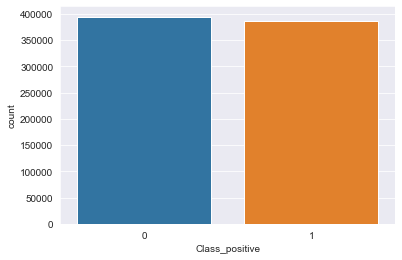

In [6]:
# оценим сбалансированность классов
print(df.Class_positive.value_counts(normalize=True))
sns.countplot(data=df, x='Class_positive');

In [12]:
# Стандартизирую данные

# функция для стандартизации,
def MinMaxScaler_column(d_col):
    mscaler = MinMaxScaler()
    mscaler.fit(df[[d_col]])
    return mscaler.transform(df[[d_col]])

for i in list(df.columns):
    df[i] = MinMaxScaler_column(i)

df.describe()

,Infimum_price,The_last_checked_price,Best_bid_median_after,Best_bid_slope_after,Best_ask_median_after,Best_ask_slope_after,Number_of_different_levels_of_demand_after,Relative_range_of_demand_change_after,Number_of_different_levels_of_offer_after,Relative_range_of_offer_change_after,Maker-Taker_slope_after,Maker-Taker_correlation_after,Share_of_makers_after,Share_of_makers_first_after,All_deals_slope_after,All_deals_correlation_after,All_volumes_slope_after,All_volumes_correlation_after,Sales_slope_after,Sales_correlation_after,Purchase_slope_after,Purchase_correlation_after,Sales_volume_slope_after,Sales_volume_correlation_after,Purchase_volume_slope_after,Purchase_volume_correlation_after,Number_of_spikes_after,Total_rise_after,Median_rise_after,Average_rise_after,Total_dynamics_after,Median_decline_after,Average_decline_after,Volumes_after_median,Sales_volume_after_median,Purchase_volume_after_median,Bid_price_by_volume_threshold_after,Seller_price_by_volume_threshold_after,Averaging_best_bids_before,Averaging_best_asks_before,Averaging_best_bids_after,Averaging_best_asks_after,Best_bid_median_before,Best_bid_slope_before,Best_ask_median_before,Best_ask_slope_before,Number_of_different_levels_of_demand_before,Relative_range_of_demand_change_before,Number_of_different_levels_of_offer_before,Relative_range_of_offer_change_before,Maker-Taker_slope_before,Maker-Taker_correlation_before,Share_of_makers_before,Share_of_makers_first_before,All_deals_slope_before,All_deals_correlation_before,All_volumes_slope_before,All_volumes_correlation_before,Sales_slope_before,Sales_correlation_before,Purchase_slope_before,Purchase_correlation_before,Sales_volume_slope_before,Sales_volume_correlation_before,Purchase_volume_slope_before,Purchase_volume_correlation_before,Number_of_spikes_before,Total_rise_before,Median_rise_before,Average_rise_before,Total_dynamics_before,Median_decline_before,Average_decline_before,Volumes_before_median,Sales_volume_before_median,Purchase_volume_before_median,Bid_price_by_volume_threshold_before,Seller_price_by_volume_threshold_before,Position_open_MODEL_price,MODEL_bargain_benefit,Second,Minute,Hour,Day,Month,Day_of_week,is_weekend,Day_of_year,Year,Quarter,Class_positive
count,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000,779943.000000
mean,0.352700,0.351320,0.739380,0.164600,0.236242,0.799308,0.097361,0.019234,0.095059,0.018569,0.665087,0.262336,0.423908,0.349163,0.151754,0.737196,0.439042,0.488430,0.151303,0.725017,0.161287,0.771829,0.879677,0.506529,0.981619,0.484044,0.067736,0.003629,0.026058,0.023118,0.162557,0.975947,0.979138,0.021835,0.002181,0.009101,0.021083,0.782084,0.402895,0.328247,0.246021,0.230059,0.537003,0.504751,0.428111,0.667718,0.092824,0.017140,0.102979,0.017165,0.673662,0.571786,0.534736,0.476017,0

## Стратифицированное разбиение выборки на тренировочную и тестовую часть

In [13]:
X = df.drop(['MODEL_bargain_benefit', 'Class_positive'], axis=1)
y = df['Class_positive']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.25)

print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))
print(y_train.mean().round(2))
print(y_test.mean().round(2))

Train shape: (584957, 89)
Test shape: (194986, 89)
0.49
0.49


## Модель линейной регрессии на "сырых" данных с кросс-валидацией

In [15]:
%%time

#Создаем объект класса логистическая регрессия
lr = linear_model.LogisticRegression(max_iter = 1000, random_state=random_state,
                                    class_weight='balanced')

#Считаем метрики на кросс-валидации 10 фолдов
cv_metrics = cross_validate(
    estimator=lr, #модель
    X=X_train, #матрица наблюдений X
    y=y_train, #вектор ответов y
    cv=10, #кросс-валидатор
    scoring=('accuracy', 'f1', 'precision', 'recall'), #метрика
    return_train_score=True #подсчёт метрики на тренировочных фолдах
)
display(cv_metrics)

{'fit_time': array([82.40948653, 78.76706696, 71.84041095, 65.02404785, 60.55583549,
        66.25921059, 63.4925406 , 64.62442279, 73.2137382 , 58.17018795]),
 'score_time': array([0.10789442, 0.10917377, 0.10697746, 0.104357  , 0.12556338,
        0.10473514, 0.11554933, 0.10836172, 0.11006927, 0.10635853]),
 'test_accuracy': array([0.50952202, 0.50863307, 0.50991521, 0.5085134 , 0.51294106,
        0.51268463, 0.50808602, 0.50609454, 0.51004359, 0.50493205]),
 'train_accuracy': array([0.51055634, 0.51075388, 0.51086785, 0.51099892, 0.51074818,
        0.51036639, 0.51110149, 0.51109672, 0.51046989, 0.51143482]),
 'test_f1': array([0.50968128, 0.50766517, 0.50526352, 0.50703018, 0.50878433,
        0.51208408, 0.50693124, 0.50375307, 0.50757706, 0.5041352 ]),
 'train_f1': array([0.50987859, 0.50881887, 0.50770722, 0.50977442, 0.50909306,
        0.50838109, 0.50866282, 0.50821492, 0.50884565, 0.5102767 ]),
 'test_precision': array([0.50393701, 0.5030552 , 0.50439307, 0.50294248, 0.50

CPU times: user 1h 6min 38s, sys: 18min 4s, total: 1h 24min 43s
Wall time: 11min 34s


In [16]:
print('Train k-fold mean accuracy: {:.2f}'.format(np.mean(cv_metrics['train_accuracy'])))
print('Valid k-fold mean accuracy: {:.2f}'.format(np.mean(cv_metrics['test_accuracy'])))

print('Train k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics['train_f1'])))
print('Valid k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics['test_f1'])))

print('Train k-fold mean precision: {:.2f}'.format(np.mean(cv_metrics['train_precision'])))
print('Valid k-fold mean precision: {:.2f}'.format(np.mean(cv_metrics['test_precision'])))

print('Train k-fold mean recall: {:.2f}'.format(np.mean(cv_metrics['train_recall'])))
print('Valid k-fold mean recall: {:.2f}'.format(np.mean(cv_metrics['test_recall'])))

Train k-fold mean accuracy: 0.51
Valid k-fold mean accuracy: 0.51
Train k-fold mean f1: 0.51
Valid k-fold mean f1: 0.51
Train k-fold mean precision: 0.51
Valid k-fold mean precision: 0.50
Train k-fold mean recall: 0.51
Valid k-fold mean recall: 0.51


### Модель логистической регрессии на "сырых" данных без кросс-валидации

In [17]:
%%time

#Создаем объект класса логистическая регрессия
lr = linear_model.LogisticRegression(max_iter = 1000, random_state=random_state,
                                    class_weight='balanced')
#Обучаем модель, минимизируя logloss
lr.fit(X_train, y_train)

y_train_pred = lr.predict(X_train)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_train, y_train_pred))

y_test_pred = lr.predict(X_test)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

         0.0       0.52      0.51      0.51    295726
         1.0       0.51      0.51      0.51    289231

    accuracy                           0.51    584957
   macro avg       0.51      0.51      0.51    584957
weighted avg       0.51      0.51      0.51    584957

              precision    recall  f1-score   support

         0.0       0.51      0.51      0.51     98576
         1.0       0.50      0.51      0.51     96410

    accuracy                           0.51    194986
   macro avg       0.51      0.51      0.51    194986
weighted avg       0.51      0.51      0.51    194986

CPU times: user 7min 58s, sys: 2min 14s, total: 10min 12s
Wall time: 1min 24s


     ◦ Precision для класса 1 составляет  0.50, то есть из всех примеров, причисленных моделью к классу успешных, 50 % действительно являются таковыми. 
     ◦ Recall для класса 1 составляет 0.51, то есть из всех примеров в действительности успешных модель посчитала успешными лишь 51 %, а остальные 49 % посчитала неуспешными. 

### Модель дерева решений на "сырых" данных без кросс-валидации

In [19]:
%%time

#Создаём модель
te = tree.DecisionTreeClassifier(
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=random_state, #генератор случайных чисел
    class_weight='balanced' #веса классов
)
#Обучаем модель на тренировочной выборке
te.fit(X_train, y_train)

y_train_pred = te.predict(X_train)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_train, y_train_pred))

y_test_pred = te.predict(X_test)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

         0.0       0.52      0.68      0.59    295726
         1.0       0.52      0.35      0.42    289231

    accuracy                           0.52    584957
   macro avg       0.52      0.52      0.50    584957
weighted avg       0.52      0.52      0.50    584957

              precision    recall  f1-score   support

         0.0       0.51      0.68      0.58     98576
         1.0       0.51      0.34      0.41     96410

    accuracy                           0.51    194986
   macro avg       0.51      0.51      0.49    194986
weighted avg       0.51      0.51      0.50    194986

CPU times: user 48.1 s, sys: 104 ms, total: 48.2 s
Wall time: 48.3 s


     ◦ Precision для класса 1 составляет  0.51, то есть из всех примеров, причисленных моделью к классу успешных, 51 % действительно являются таковыми. 
     ◦ Recall для класса 1 составляет 0.34, то есть из всех примеров в действительности успешных модель посчитала успешными лишь 34 %, а остальные 66 % посчитала неуспешными. 